# Two Sigma Connect: Rental Listing Inquiries (kaggle)
[How much interest will a new rental listing on RentHop receive?][1]

[1]:https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries

#### TODO LIST
1. Spot-check algorithms
    - binarize target variable
    - MinMaxScaler for 'bathrooms', 'bedrooms', 'price'
2. Explore
    - 
 
3. Advanced feature engineering options
    - Description
        - binarize features, i.e. BOW
        - LDA with description
    - 


In [1]:
import numpy as np
arr_2 = np.array([[  1,   2,   3],
                  [  4,   5,   6],
                  [ 10,  20,  30],
                  [ 40,  50,  60],
                  [100, 200, 300],
                  [400, 500, 600]])
arr_2.shape

(6, 3)

Expand dimensions:

In [2]:
arr_2[np.newaxis, :, :] == \
    np.expand_dims(arr_2, 0)  # insert new axis at index in shape tuple

array([[[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]]], dtype=bool)

In [3]:
arr_2.reshape(-1, 2)

array([[  1,   2],
       [  3,   4],
       [  5,   6],
       [ 10,  20],
       [ 30,  40],
       [ 50,  60],
       [100, 200],
       [300, 400],
       [500, 600]])

In [4]:
arr_2[np.newaxis, :3 , :2]

array([[[ 1,  2],
        [ 4,  5],
        [10, 20]]])

In [5]:
arr_3 = np.vstack((arr_2[np.newaxis, :3],
                   arr_2[np.newaxis, 3:]))

arr_3 == np.concatenate((arr_2[np.newaxis, :3],
                         arr_2[np.newaxis, 3:]), axis=0)

array([[[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]]], dtype=bool)

In [307]:
from copy import deepcopy
import pdb
import warnings
from imp import reload
import time
from pprint import pprint
import random

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import (StratifiedShuffleSplit, train_test_split,
                                     validation_curve)
from dask_searchcv import GridSearchCV as DaskGridSearchCV
from grid_explore import GridSearchExplorer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss, make_scorer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import (LabelBinarizer, LabelEncoder,
                                   MinMaxScaler, StandardScaler)
from sklearn.ensemble import (GradientBoostingClassifier,
                              RandomForestClassifier)
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.linear_model import LogisticRegression
from scipy import stats
import spacy

import pdir

from plot_learning_curve import plot_learning_curve

%matplotlib inline

pd.set_option('display.float_format', lambda x: '%.5f' % x)

SEED = 42
np.random.seed(SEED)

DAT_DIR = './data/'
SUBM_DIR = './submissions/'
TEST_DIR = './tests/'
TRAIN_FP = ''.join([DAT_DIR, 'train.json'])
TEST_FP = ''.join([DAT_DIR, 'test.json'])
SAMPLE_FP = ''.join([DAT_DIR, 'sample_submission.csv'])


# using built-in 'neg_log_loss' scoring param used for simplicity
# source code show exact same make_scorer call, kept for reference
scorer = make_scorer(log_loss, greater_is_better=False,
                        needs_proba=True)

scoring = 'neg_log_loss'

In [7]:
def save_submission(preds, fp):
    """Ensures correct format and class ordering."""
    submit = (pd.DataFrame(preds,
                           columns=['high', 'low', 'medium'],
                           index=X_sub.index)
              .loc[:, ['high', 'medium', 'low']])
    
    # ensure label ordering correct
    assert submit.high.sum() < submit.medium.sum() < submit.low.sum(), (
        'Interest level probabilities are mismatched')
    
    submit.to_csv(fp)
    
    return submit

In [8]:
def plot_validation_curve(clf, param_name, param_range, scorer,
                          ylim=None, xscale='linear', n_jobs=-1):
    """Plots vaildation curve for given hyperparamters.
    
    Parameters
    ----------
    clf : sklearn Classifier
    param_name :  str
    param_range : iterable
    kwargs : passed to matplotlib plot
    
    Returns
    -------
    plt : matplotlib plot
    """
    
    train_scores, valid_scores = validation_curve(
        clf, X_train, y_train, param_name, n_jobs=n_jobs,
        param_range=param_range, scoring=scorer) 
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)
    
    
    plt.title('Validation Curve with {}'.format(type(clf).__name__))
    plt.xlabel(param_name)
    plt.ylabel('Score')
    
    lw = 2
    
    plt.plot(param_range, train_scores_mean, label='Training score',
             color='darkorange', lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color='darkorange', lw=lw)
    
    plt.plot(param_range, valid_scores_mean, label='Cross-validation score',
             color='navy', lw=lw)
    plt.fill_between(param_range, valid_scores_mean - valid_scores_std,
                     valid_scores_mean + valid_scores_std, alpha=0.2,
                     color='navy', lw=lw)
    
    if xscale=='log':
        plt.gca().set_xscale('log')
    elif xscale!='linear':
        raise ValueError('Must be valid xscale')
        
    if ylim is not None:
        plt.ylim(*ylim)
    plt.legend(loc='best')
    
    return plt

In [354]:
def read_rental_interest_json(fp, frac=None, random_state=None):
    """Reads Two Sigma Connect: Rental Listing Inquiries json."""
    
    df = (pd.read_json(TRAIN_FP)
          .set_index('listing_id')
         )
    df.created = pd.to_datetime(df.created)
    
    return df

In [310]:
# from PRE-LEARNING, make sure up-to-date
def read_rental_interest(fp, frac=None, 
                         drop_pr_outliers=False, 
                         drop_bedbath_outl=False):
    """Reads Two Sigma Connect: Rental Listing Inquiries json."""
    
    df = (pd.read_json(TRAIN_FP)
          .set_index('listing_id')
         )
    df.created = pd.to_datetime(df.created)
    df.interest_level = df.interest_level.replace(
        ['low', 'medium', 'high'], [1, 2, 3]
    )
    if drop_pr_outliers:
        df = drop_price_outliers(df, multiple=2.5, log=True, output=False)
        
    if drop_bedbath_outl:
        df = df.loc[(df.bedrooms <= 4) & (df.bathrooms.isin([1, 2, 3]))]
    
    # stratified sample
    if frac is not None:
        df = (df.groupby('interest_level')
              .apply(lambda x: x.sample(frac=frac, random_state=SEED))
        )
    
    return df

In [180]:
def drop_outliers(df):
    df = drop_price_outliers(df, multiple=2.5, log=True, output=False)
        
    df = df.loc[(df.bedrooms <= 4) & (df.bathrooms.isin([1, 2, 3]))]
    
    return df

# Pre-learning

## Outlier detection and imputations

In [166]:
def is_outlier_val(col, multiple=1.5, log=False):
    """Detects outliers using Tukey's method.

    Technique determines an outlier if it fall outside
    the interquartile range expanded by 50% on either side.

    Parameters
    ----------
    col : pandas.Series
        Specific feature to be assessed

    Returns
    -------
    result : pandas.Series
        Of boolean values, true if value is outlier
    """
    if log:
        col = np.log(col+1)
    q1, q3 = col.quantile(q=.25), col.quantile(q=.75)
    step = multiple * (q3-q1)
    lo, hi = q1-step, q3+step

    result = (col<lo) | (col>hi)
    return result

In [48]:
df = read_rental_interest_json(TRAIN_FP)
df.interest_level = df.interest_level.replace(
    ['low', 'medium', 'high'], [1, 2, 3])
df_start = df.copy()

### Price

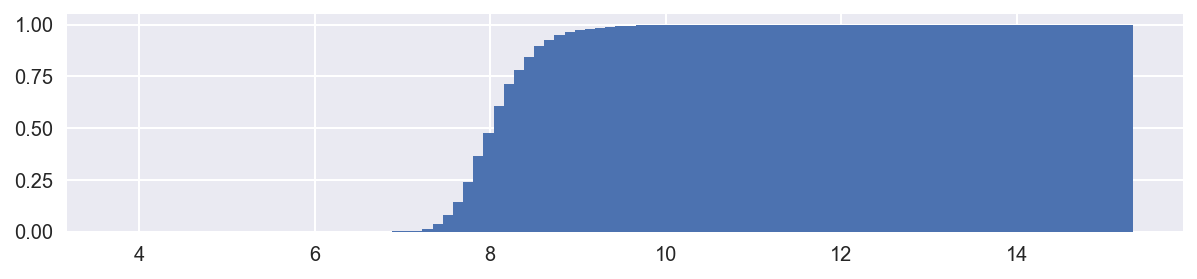

In [12]:
plt.figure(figsize=(10, 2))
plt.hist(np.log(df.price), bins=100, cumulative=True, normed=True)
plt.show()

In [183]:
def drop_price_outliers(df, multiple=2.5, log=True, output=False):
    pre_len = len(df)
    df = df[~is_outlier_val(df.price, multiple=multiple)]
    post_len = len(df)
    if output:
        print('Dropped {} outliers ({:.2%})'
              .format(pre_len-post_len, (pre_len-post_len)/pre_len))
    return df

In [320]:
df_no_out = drop_price_outliers(df, output=True)

Dropped 713 outliers (1.44%)


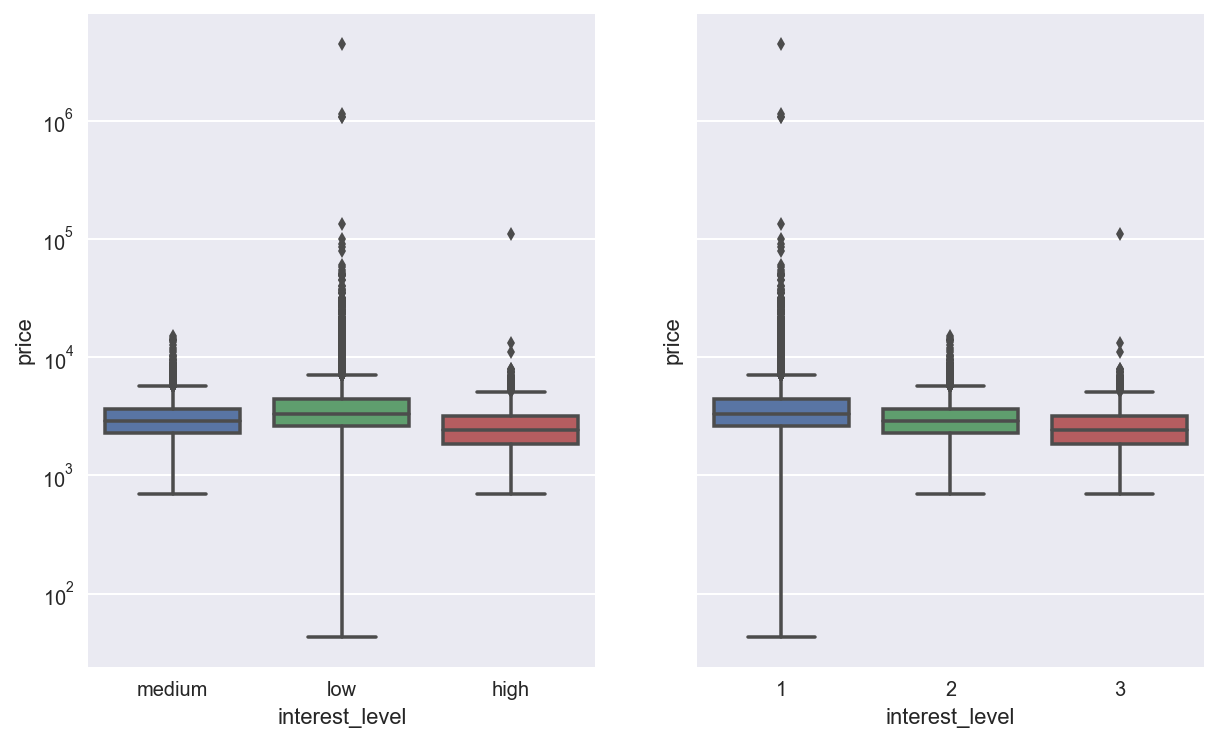

In [316]:
sns.set()
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10, 6))
sns.boxplot(
    y='price', x='interest_level', data=df, ax=ax1).set_yscale('log')
sns.boxplot(
    y='price', x='interest_level', data=df_no_out, ax=ax2).set_yscale('log')

### Bedrooms and bathrooms

In [ ]:
df = read_rental_interest(TRAIN_FP)

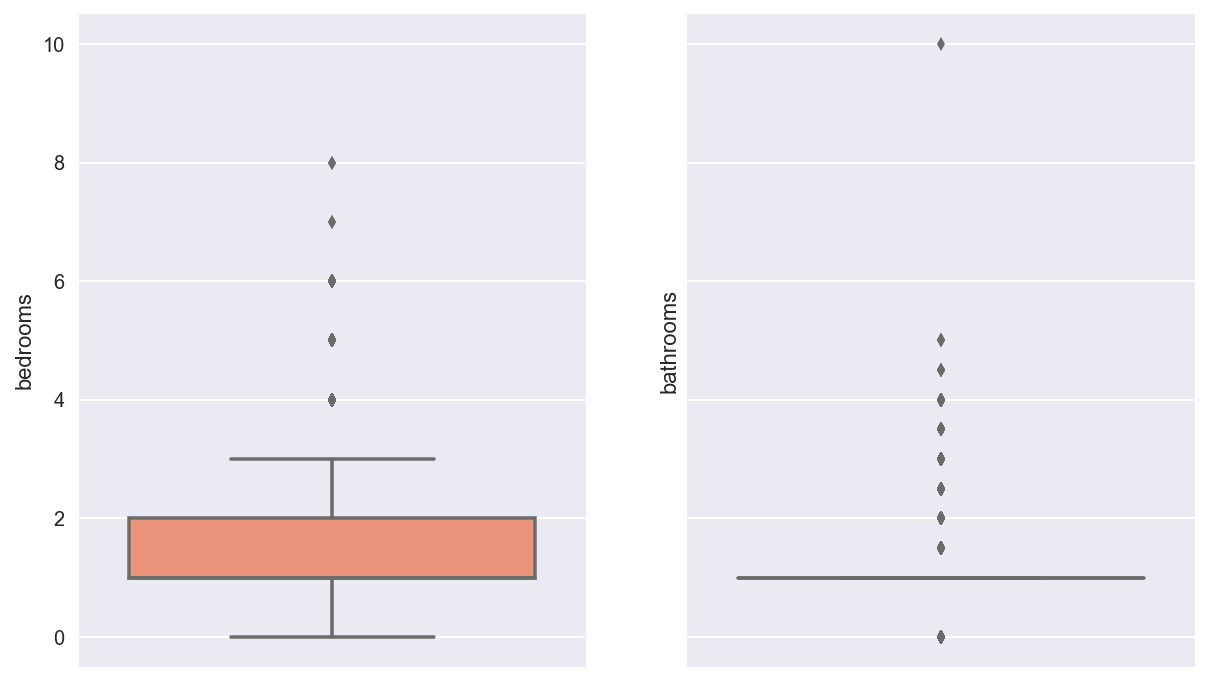

In [103]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10, 6))
sns.boxplot(
    y='bedrooms', data=df_start, ax=ax1)
sns.boxplot(
    y='bathrooms', data=df, ax=ax2)

In [146]:
df.bedrooms.value_counts(normalize=False)

1    15749
2    14578
0     9460
3     7125
4     1805
5      174
6       30
8        1
7        1
Name: bedrooms, dtype: int64

## Exploring

In [101]:
df = read_rental_interest(TRAIN_FP, drop_pr_outliers=True)

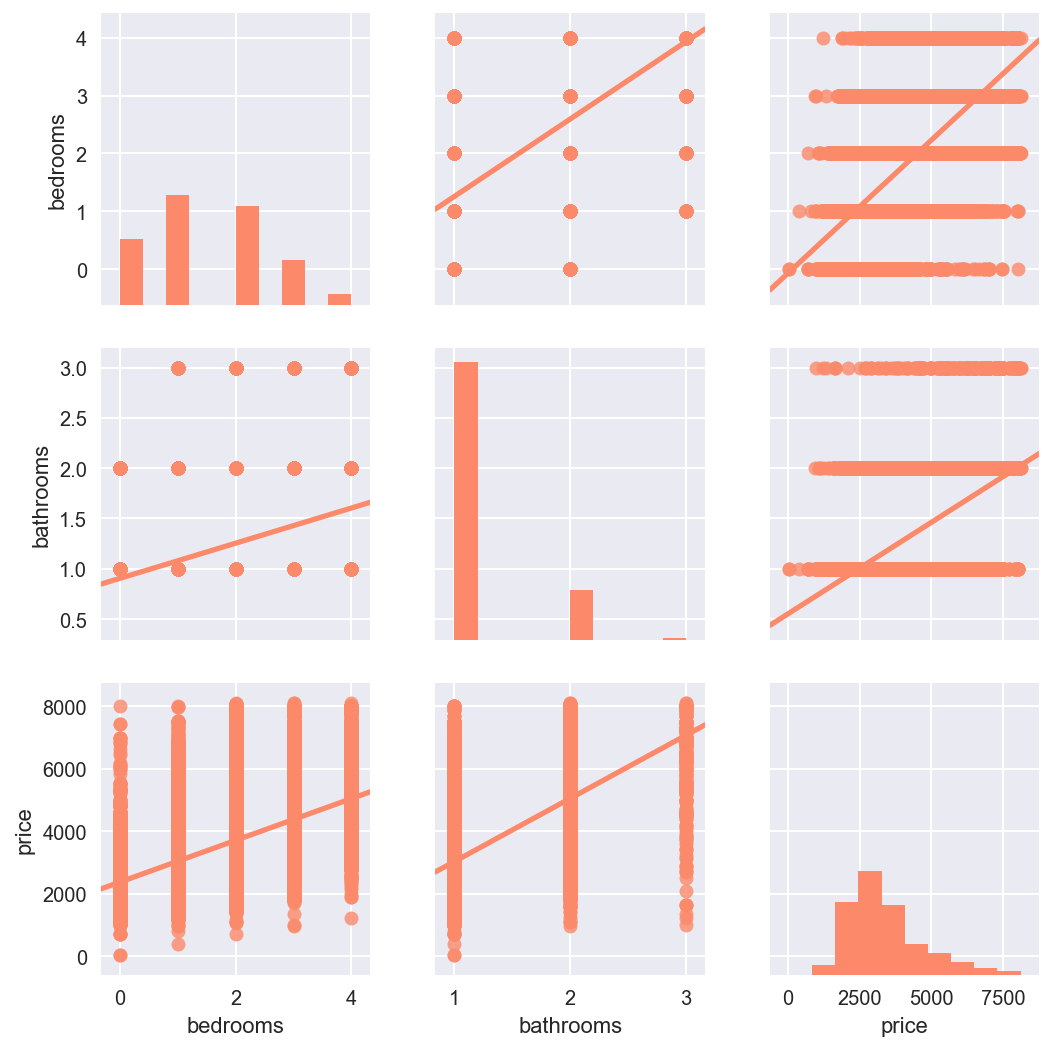

In [184]:
data = df[['bedrooms', 'bathrooms', 'price']].pipe(drop_outliers)

sns.pairplot(
    data=data,
    kind='reg'
)

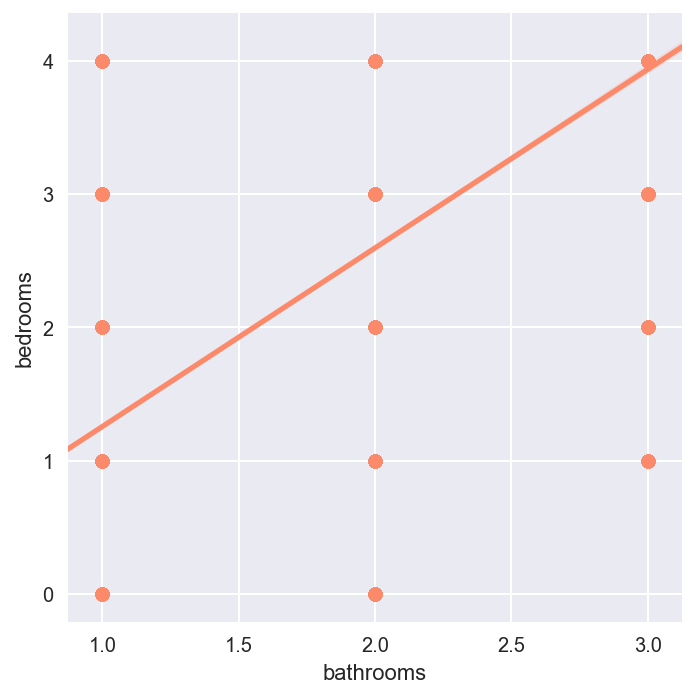

In [187]:
data = df[['bedrooms', 'bathrooms', 'price']].pipe(drop_outliers)
sns.lmplot(x='bathrooms', y='bedrooms', data=data)

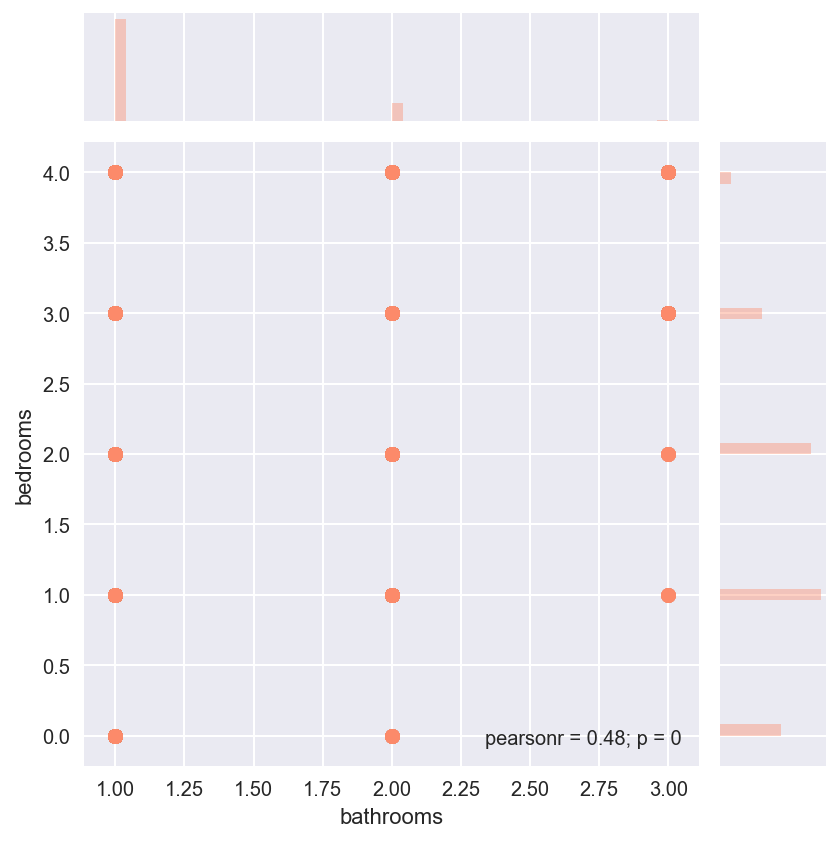

In [188]:
data = df[['bedrooms', 'bathrooms', 'price']].pipe(drop_outliers)
sns.jointplot(x='bathrooms', y='bedrooms', data=data)

In [50]:
sns.set(palette=sns.color_palette('Reds', 4)[1:])

In [51]:
df['lg_pr']   = np.log(df.price)
df['pr_b']    = pd.cut(df.lg_pr, bins=10)
df['month']     = df.created.map(lambda x: x.month).astype(int)
df['day']     = df.created.map(lambda x: x.day).astype(int)
df['day_name'] = df.created.dt.weekday_name

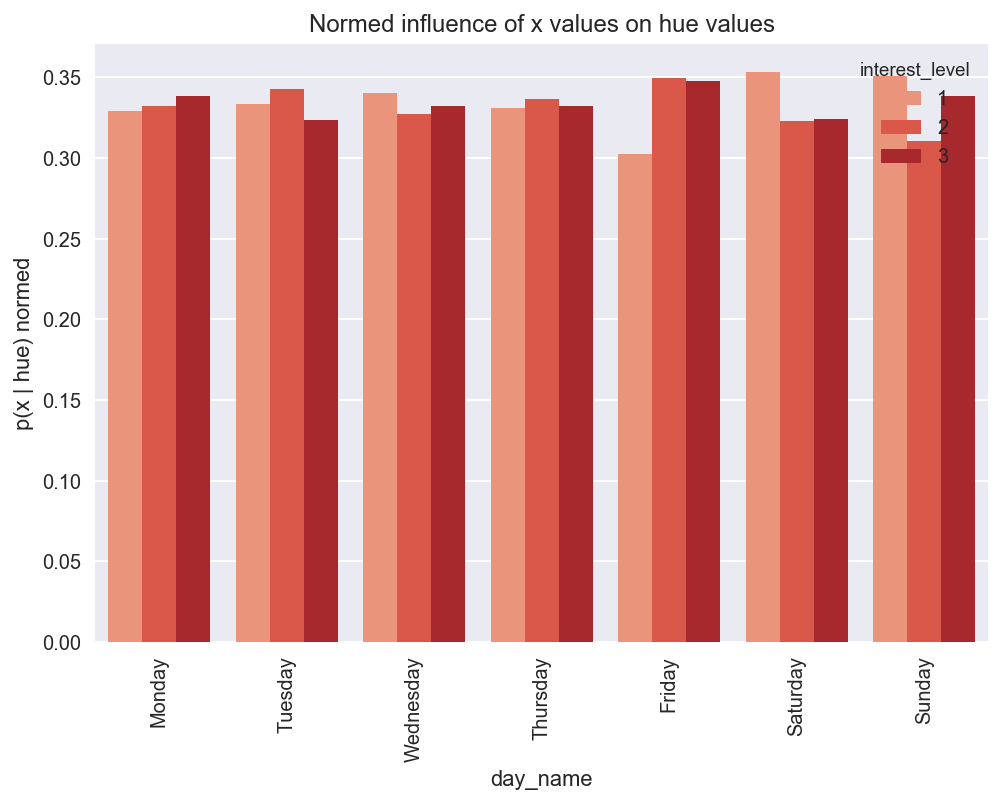

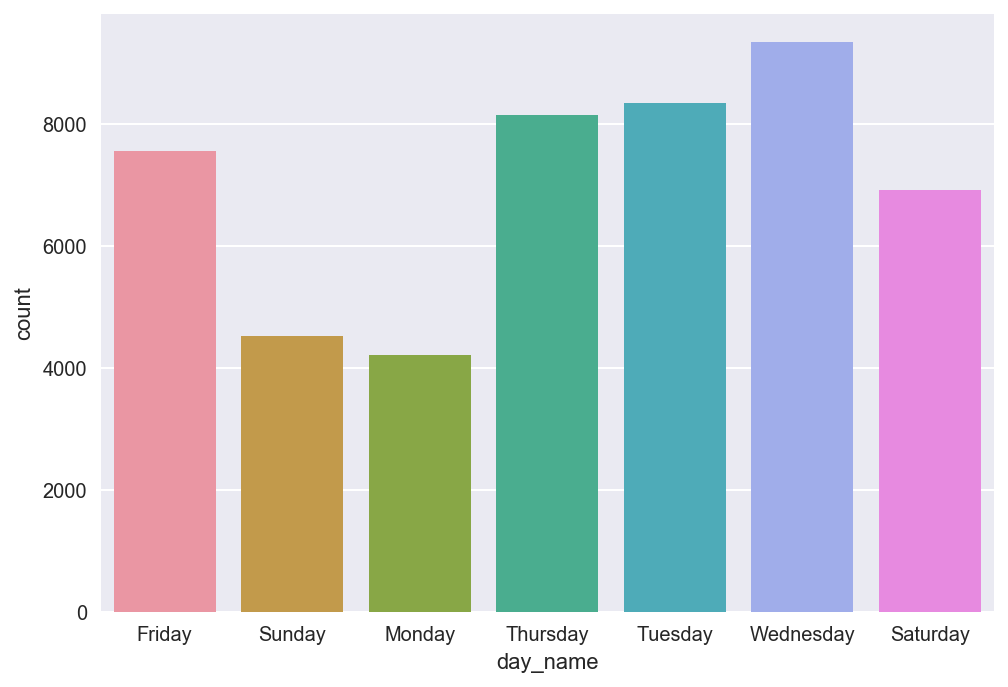

In [52]:
x = 'day_name'
hue = 'interest_level'
data = df
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday',
             'Friday', 'Saturday', 'Sunday']

# first normed for class (hue) imbalance
ylabel = 'p(x | hue)'.format(x, hue)
prob_x = (data.groupby(hue)[x]
          .value_counts(normalize=True)
          .rename('prob')
          .reset_index()
          .sort_values(x))

# then normed for categorical (x) imbalance
rel_prob = (prob_x.groupby(x)
            .apply(lambda x: x.assign(prob=x.prob/x.prob.sum()))
            .reset_index(drop=True))

p = sns.barplot(x=x, y='prob', hue=hue, data=rel_prob, order=day_order)
p.set_ylabel(ylabel+ ' normed')
plt.setp(p.get_xticklabels(), rotation=90)

plt.title('Normed influence of x values on hue values')
plt.show()

sns.countplot(data[x])
plt.show()

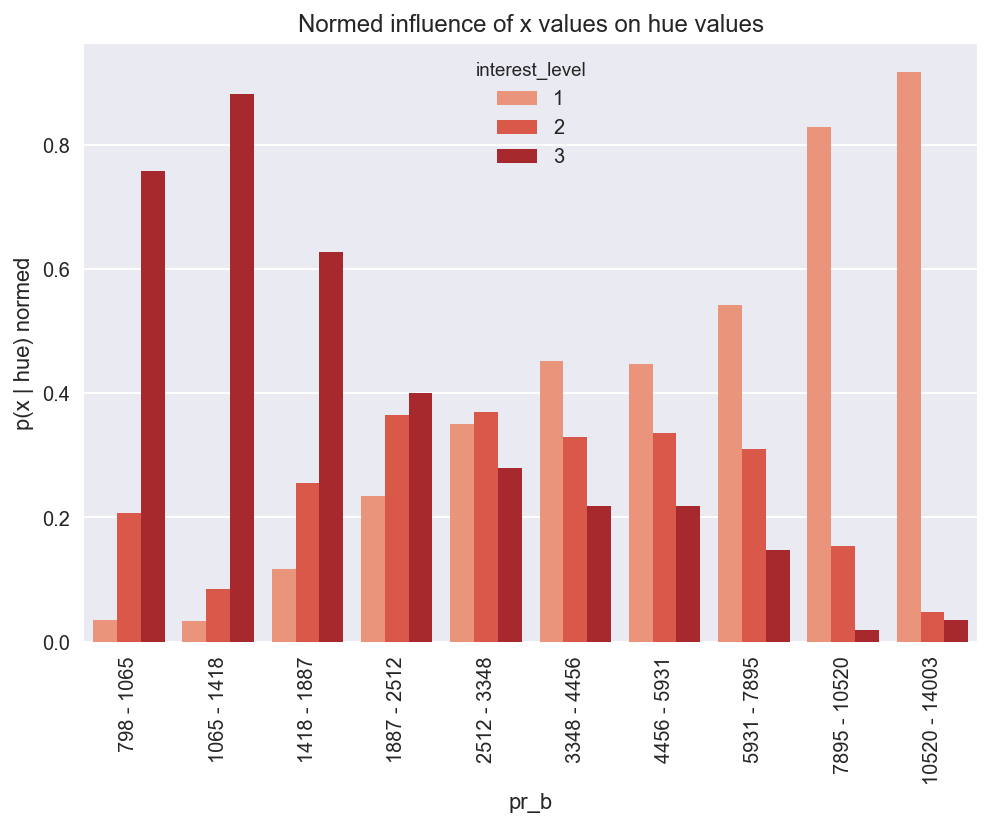

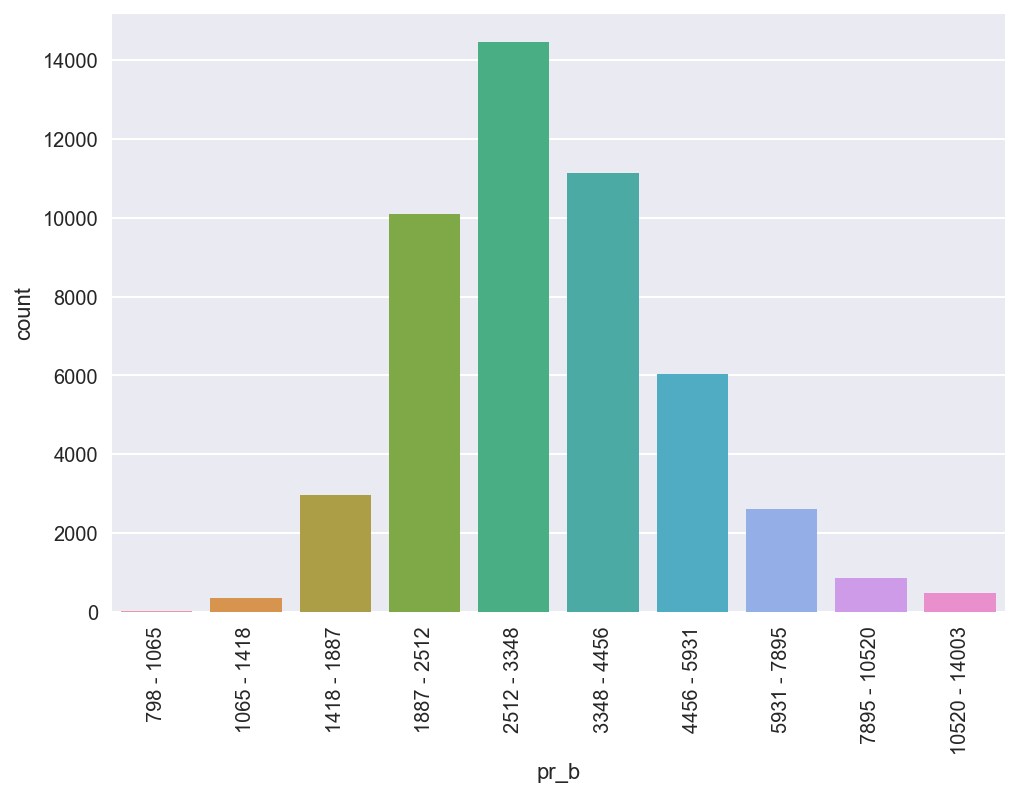

In [53]:
x = 'pr_b'
hue = 'interest_level'
data = df

# first normed for class (hue) imbalance
ylabel = 'p(x | hue)'.format(x, hue)
prob_x = (data.groupby(hue)[x]
          .value_counts(normalize=True)
          .rename('prob')
          .reset_index()
          .sort_values(x))

# then normed for categorical (x) imbalance
rel_prob = (prob_x.groupby(x)
            .apply(lambda x: x.assign(prob=x.prob/x.prob.sum()))
            .reset_index(drop=True))

p = sns.barplot(x=x, y='prob', hue=hue, data=rel_prob)


xtickslables = []
for lbl in p.get_xticklabels():
    import re
    lo, hi = re.findall(r'[0-9.]+', lbl.get_text())
    lo, hi = np.exp(float(lo)), np.exp(float(hi))
    xtickslables.append('{:.0f} - {:.0f}'.format(lo, hi))
p.set_xticklabels(xtickslables)

p.set_ylabel(ylabel+ ' normed')
plt.setp(p.get_xticklabels(), rotation=90)

plt.title('Normed influence of x values on hue values')
plt.show()

p = sns.countplot(data[x])
p.set_xticklabels(xtickslables, rotation=90)
plt.show()

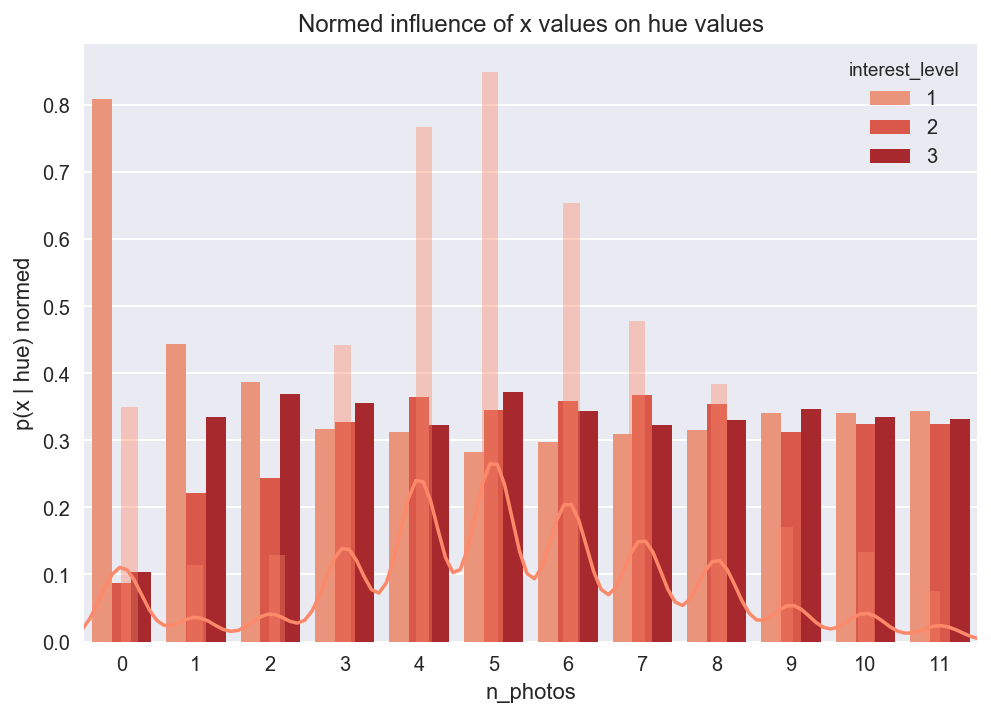

In [54]:
# do number of photos affect interest?
df['n_photos'] = df.photos.map(lambda x: len(x))

x = 'n_photos'
hue = 'interest_level'
data = df.query('n_photos < 12')

# first normed for class (hue) imbalance
ylabel = 'p(x | hue)'.format(x, hue)
prob_x = (data.groupby(hue)[x]
          .value_counts(normalize=True)
          .rename('prob')
          .reset_index()
          .sort_values(x))

# then normed for categorical (x) imbalance
rel_prob = (prob_x.groupby(x)
            .apply(lambda x: x.assign(prob=x.prob/x.prob.sum()))
            .reset_index(drop=True))

p = sns.barplot(x=x, y='prob', hue=hue, data=rel_prob)
sns.distplot(data[x], ax=plt.gca())

p.set_ylabel(ylabel+ ' normed')
plt.title('Normed influence of x values on hue values')

plt.show()

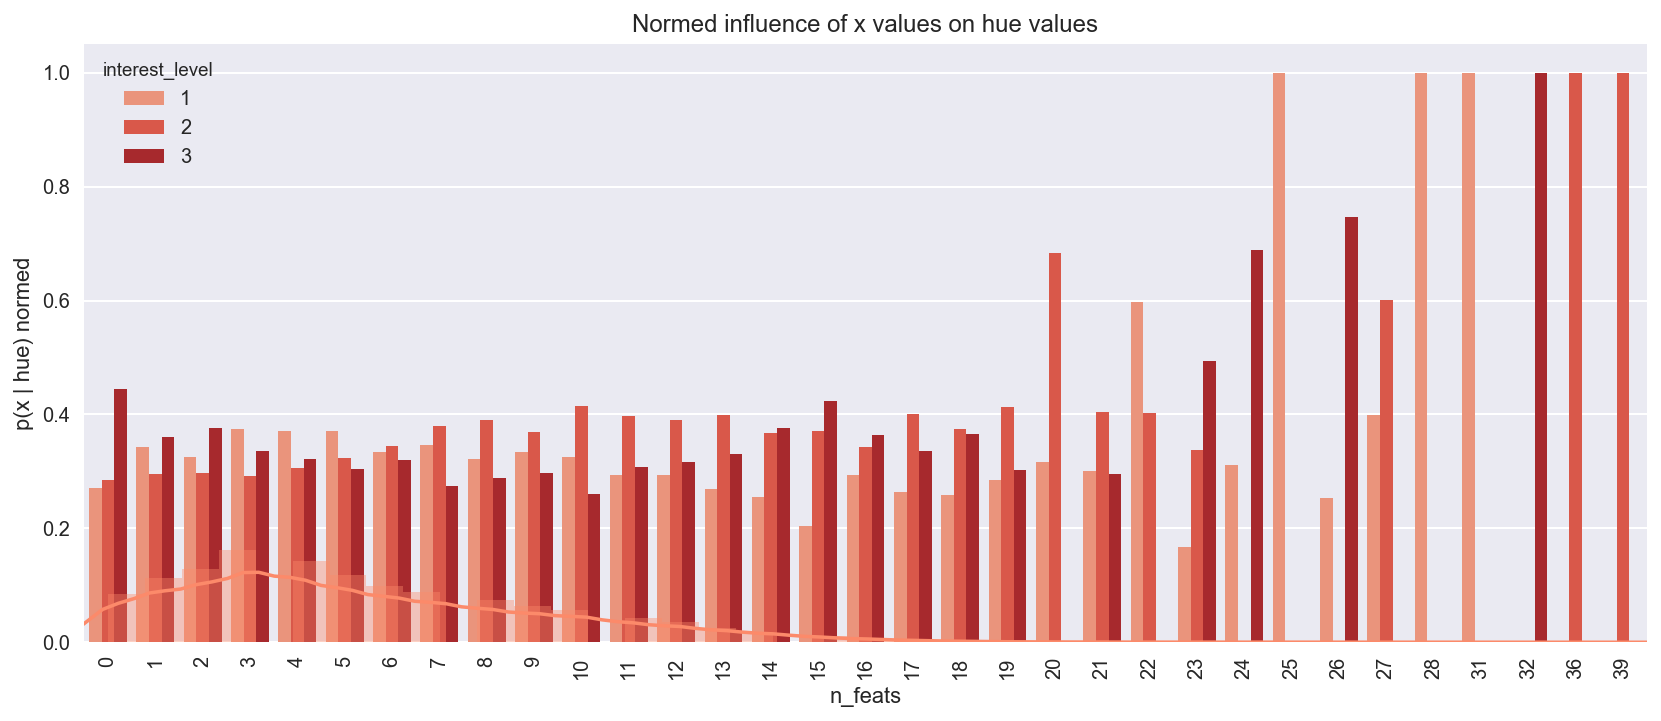

In [55]:
# do number of features affect interest?
df['n_feats'] = df.features.apply(lambda x: len(x))

x = 'n_feats'
hue = 'interest_level'
data = df

# first normed for class (hue) imbalance
ylabel = 'p(x | hue)'.format(x, hue)
prob_x = (data.groupby(hue)[x]
          .value_counts(normalize=True)
          .rename('prob')
          .reset_index()
          .sort_values(x))

# then normed for categorical (x) imbalance
rel_prob = (prob_x.groupby(x)
            .apply(lambda x: x.assign(prob=x.prob/x.prob.sum()))
            .reset_index(drop=True))

p = sns.barplot(x=x, y='prob', hue=hue, data=rel_prob)
p.set_ylabel(ylabel+ ' normed')
plt.setp(p.get_xticklabels(), rotation=90)

plt.title('Normed influence of x values on hue values')
sns.distplot(data[x], ax=plt.gca())
plt.gcf().set_figwidth(14)
plt.show()

__Interesting__: No features ones have higher interest than others, rest too noisy

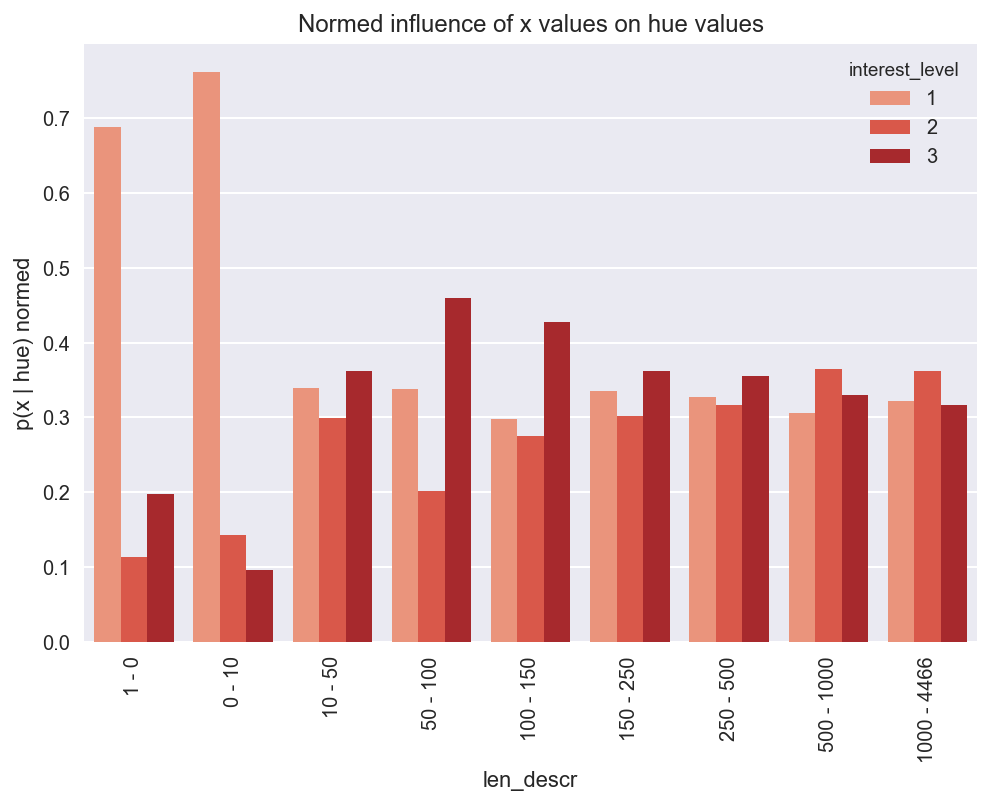

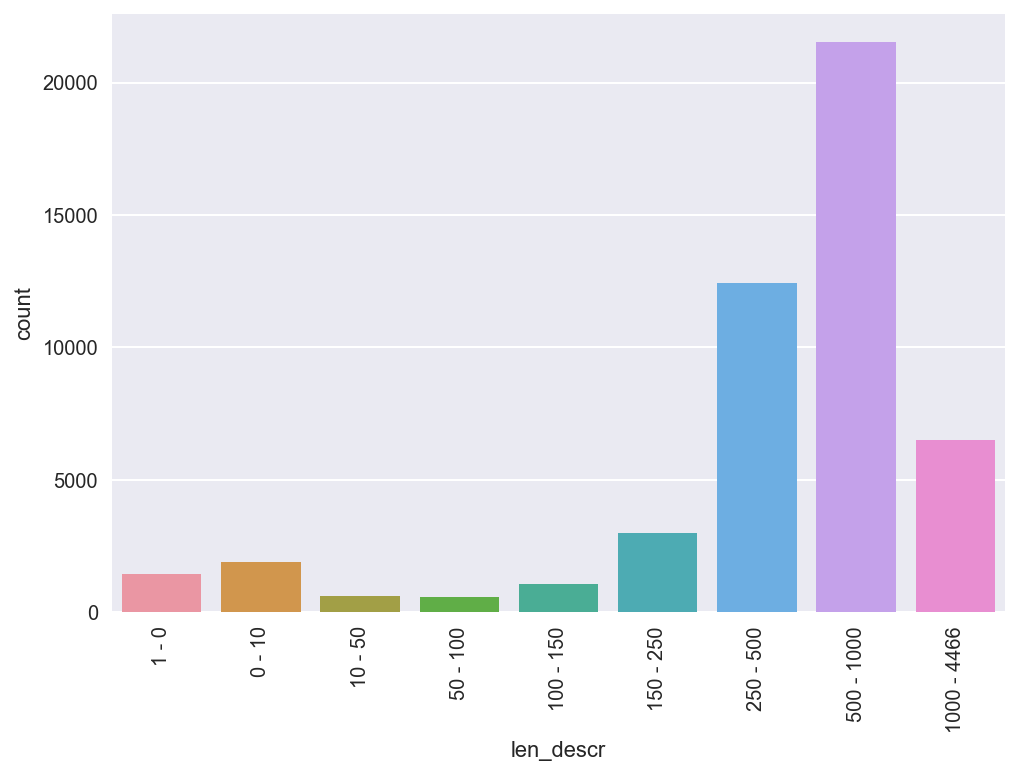

In [56]:
# does length of description affect interest?
# do number of features affect interest?

x = 'len_descr'
hue = 'interest_level'
data = df.assign(len_descr=df.description.apply(lambda x: len(x)))
bins = [-1, 0, 10, 50, 100, 150, 250, 500, 1000, data.len_descr.max()]
data.len_descr = pd.cut(data.len_descr, bins)

# first normed for class (hue) imbalance
ylabel = 'p(x | hue)'.format(x, hue)
prob_x = (data.groupby(hue)[x]
          .value_counts(normalize=True)
          .rename('prob')
          .reset_index()
          .sort_values(x))

# then normed for categorical (x) imbalance
rel_prob = (prob_x.groupby(x)
            .apply(lambda x: x.assign(prob=x.prob/x.prob.sum()))
            .reset_index(drop=True))

p = sns.barplot(x=x, y='prob', hue=hue, data=rel_prob)

xtickslables = []
for lbl in p.get_xticklabels():
    import re
    lo, hi = re.findall(r'[0-9.]+', lbl.get_text())
    lo, hi = float(lo), float(hi)
    xtickslables.append('{:.0f} - {:.0f}'.format(lo, hi))
p.set_xticklabels(xtickslables, rotation=90)

p.set_ylabel(ylabel+ ' normed')


plt.title('Normed influence of x values on hue values')
plt.show()

p = sns.countplot(data[x])
p.set_xticklabels(xtickslables, rotation=90)
plt.show()

In [57]:
# see if display address related to geo-coords
df.display_address.value_counts().head()

Broadway            433
East 34th Street    355
Second Avenue       349
Wall Street         330
West 37th Street    287
Name: display_address, dtype: int64

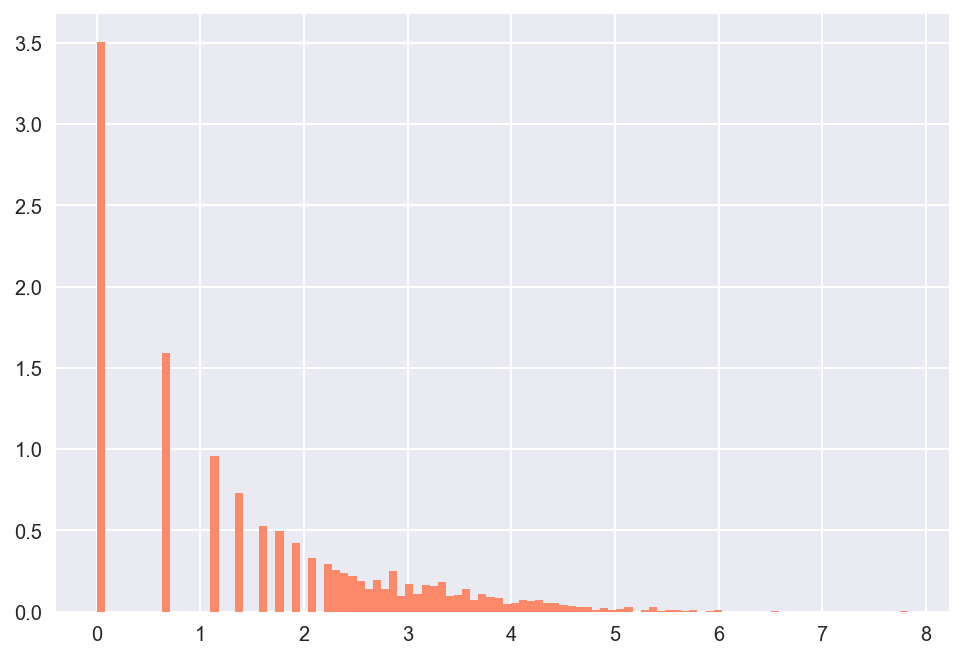

In [58]:
n_posts = df.manager_id.value_counts().rename('n_posts')
lg_posts = np.log(n_posts)

# plt.hist(n_posts[n_posts > 4], cumulative=True, normed=True, bins=100);
plt.hist(np.log(n_posts), bins=100, cumulative=False, normed=True)
plt.show()

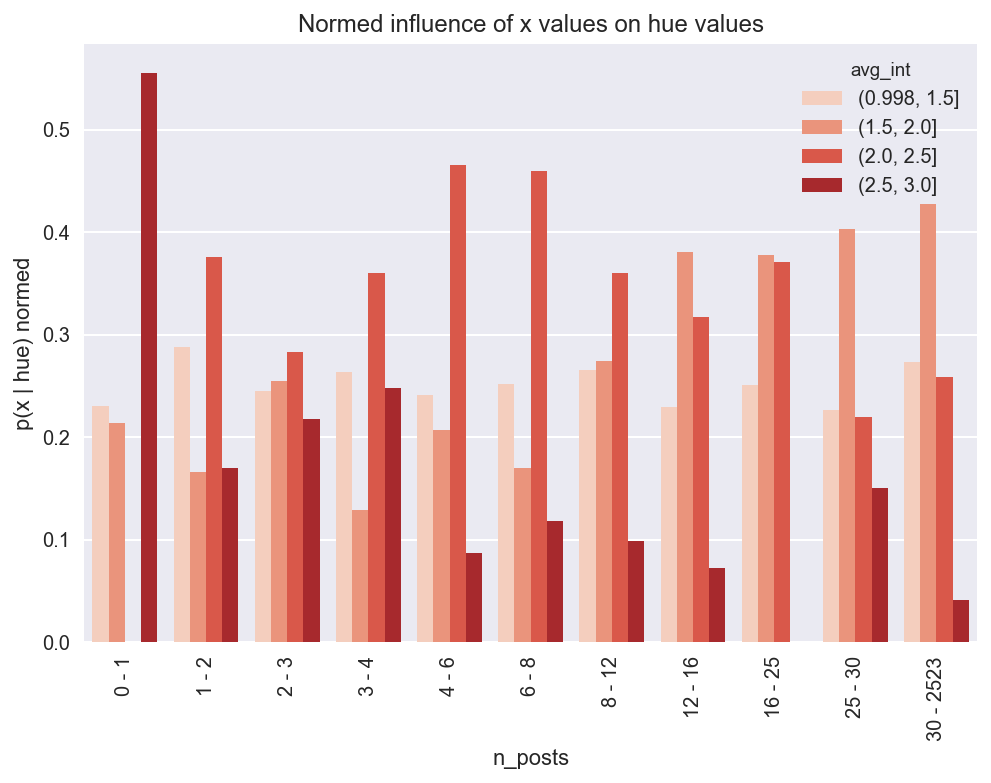

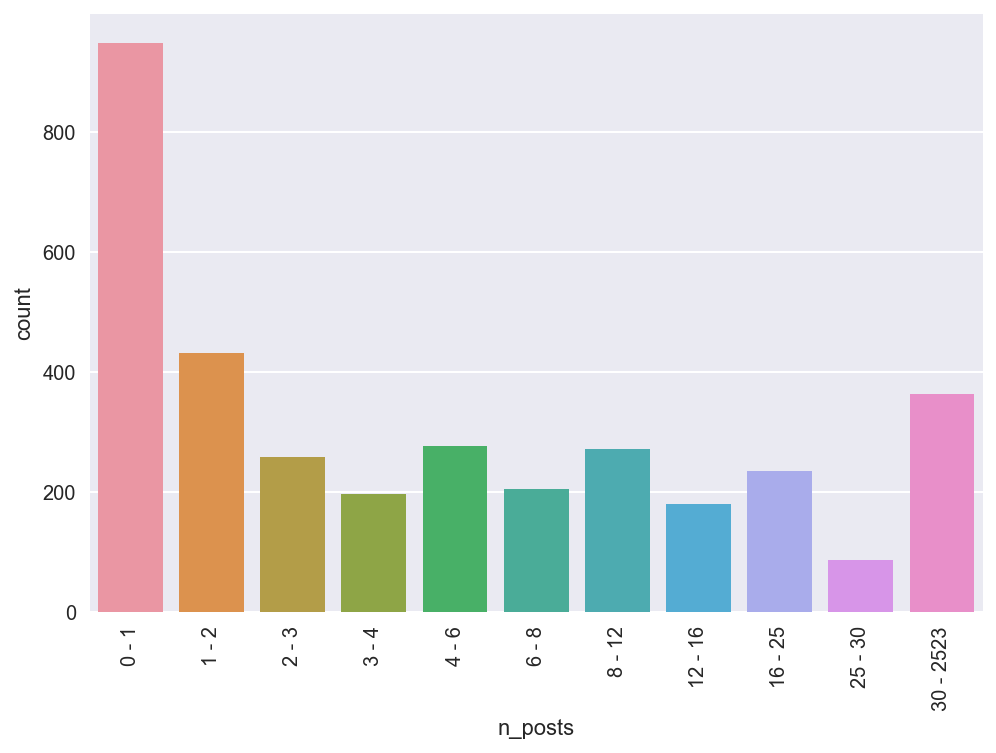

In [69]:
# see if activity of agents affects interest
avg_int = df.groupby('manager_id')['interest_level'].mean().rename('avg_int')
data = pd.concat([n_posts, avg_int], axis=1)

bins = [0, 1, 2, 3, 4, 6, 8, 12, 16, 25, 30, data.n_posts.max()]
data.n_posts = pd.cut(data.n_posts, bins)
avg_int_bins = 4
data.avg_int = pd.cut(data.avg_int, avg_int_bins)

x = 'n_posts'
hue = 'avg_int'

# first normed for class (hue) imbalance
ylabel = 'p(x | hue)'.format(x, hue)
prob_x = (data.groupby(hue)[x]
          .value_counts(normalize=True)
          .rename('prob')
          .reset_index()
          .sort_values(x))

# then normed for categorical (x) imbalance
rel_prob = (prob_x.groupby(x)
            .apply(lambda x: x.assign(prob=x.prob/x.prob.sum()))
            .reset_index(drop=True))

p = sns.barplot(x=x, y='prob', hue=hue, data=rel_prob,
                palette=sns.color_palette('Reds', avg_int_bins))
p.set_ylabel(ylabel+ ' normed')

xtickslables = []
for lbl in p.get_xticklabels():
    import re
    lo, hi = re.findall(r'[0-9.]+', lbl.get_text())
    lo, hi = float(lo), float(hi)
    xtickslables.append('{:.0f} - {:.0f}'.format(lo, hi))
p.set_xticklabels(xtickslables)

plt.setp(p.get_xticklabels(), rotation=90)

plt.title('Normed influence of x values on hue values')
plt.show()

p = sns.countplot(data[x])
p.set_xticklabels(xtickslables, rotation=90)
plt.show()

In [65]:
avg_int = df.groupby('manager_id')['interest_level'].mean().rename('avg_int')
data = pd.concat([n_posts, avg_int], axis=1)
data.n_posts.value_counts().sort_index().head()
data.query('n_posts == 1').avg_int.value_counts(normalize=True).head()

1.000   0.721
2.000   0.184
3.000   0.095
Name: avg_int, dtype: float64

## Geo-coordinates, clustering or kNN

Are buildings important for clustering?

In [30]:
df = read_rental_interest_json(TRAIN_FP)

In [31]:
g = df[df.building_id!=0].groupby('building_id')
g.apply(lambda x: x.latitude.min()==x.latitude.max()).sum()/(len(g))

0.85431773236651287

In [32]:
len(g)  # num buildings

7585

In [33]:

is_outlier = (is_outlier_val(df.latitude)) | is_outlier_val(df.longitude)
df_ = df.loc[~is_outlier]
is_null = (df.building_id=='0') | (df.latitude==0) | (df.longitude==0)
df_ = df.loc[~is_null, ['latitude', 'longitude']]
print('Fraction null: {:.3f}'.format((len(df)-len(df_))/len(df)))

Fraction null: 0.213


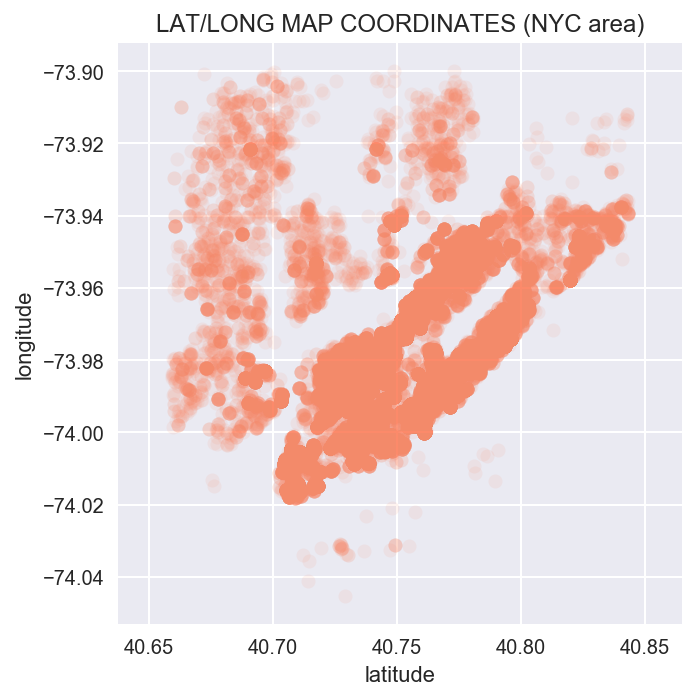

In [34]:
def plot_coords(data, hue=None, alpha=None, palette=None):
    
    plt.figure(figsize=(10, 8))
    sns.lmplot(x='latitude', y='longitude',
               hue=hue, data=data,
               fit_reg=False,
               palette=palette,
               scatter_kws=dict(alpha=alpha)
    )

    plt.title('LAT/LONG MAP COORDINATES (NYC area)')
    plt.tight_layout()
    
    return plt.gca()


plot_coords(df_, alpha=.1)

In [35]:
print('{:.0%} non-unique coords'
      .format(df.duplicated(df.columns, keep=False).sum()/len(df_))
)

89% non-unique coords


In [36]:
from hdbscan import HDBSCAN

clust = HDBSCAN(min_cluster_size=5, metric='l1', gen_min_span_tree=True)
clust.fit(df_)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='l1', min_cluster_size=5, min_samples=None, p=None,
    prediction_data=False)

In [37]:
print('{} clusters total'.format(len(np.unique(clust.labels_))))
print('{:.0f} per clust avg'.format(len(df)/len(np.unique(clust.labels_))))
print('{:.0%} noise points'.format(sum(clust.labels_==-1)/len(df_)))

2036 clusters total
24 per clust avg
10% noise points


In [38]:
df.groupby(clust.labels_).apply(
    lambda x: np.sum(~x.duplicated(keep=False))/1).sort_values(ascending=False)

-1      2137.000
 642      27.000
 637      24.000
 1160     19.000
 998      14.000
 897      13.000
 1102     12.000
 207      11.000
 1056     11.000
 946      10.000
 1208      9.000
 961       9.000
 894       9.000
 1651      9.000
 276       9.000
 630       9.000
 907       8.000
 6         8.000
 896       8.000
 1271      8.000
 242       8.000
 73        8.000
 1017      8.000
 1446      8.000
 1297      7.000
 249       7.000
 1071      7.000
 1091      7.000
 1356      7.000
 166       7.000
          ...   
 813       0.000
 1546      0.000
 1545      0.000
 1543      0.000
 1553      0.000
 818       0.000
 1542      0.000
 821       0.000
 822       0.000
 1540      0.000
 1539      0.000
 809       0.000
 806       0.000
 1565      0.000
 1559      0.000
 1562      0.000
 1561      0.000
 793       0.000
 794       0.000
 795       0.000
 1560      0.000
 1558      0.000
 805       0.000
 799       0.000
 800       0.000
 1557      0.000
 1555      0.000
 1554      0.0

In [39]:
clust.probabilities_.shape

(38857,)

In [40]:
pd.Series(np.bincount(clust.labels_+1)).describe()

count   2036.000
mean      19.085
std       87.987
min        5.000
25%        8.000
50%       12.000
75%       19.000
max     3907.000
dtype: float64

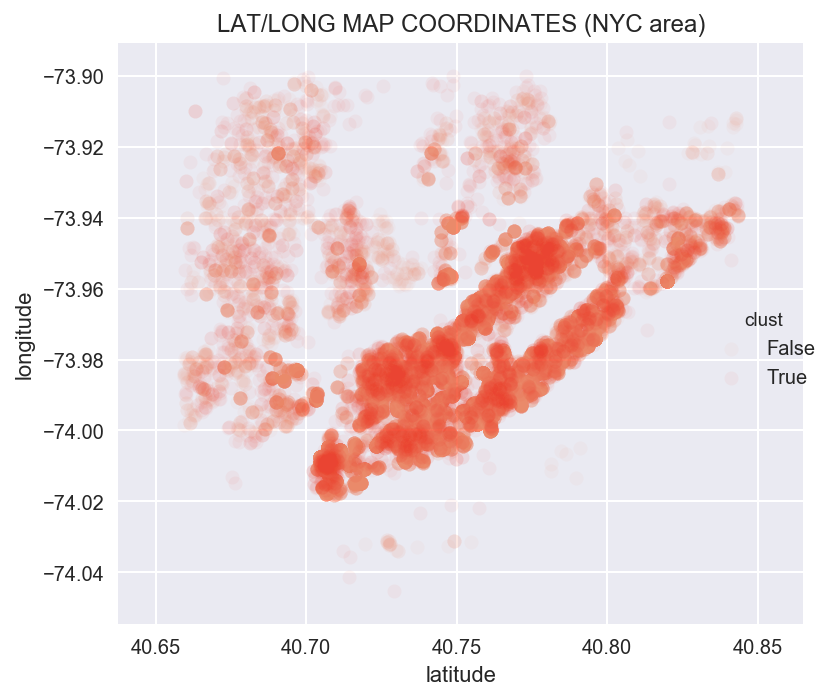

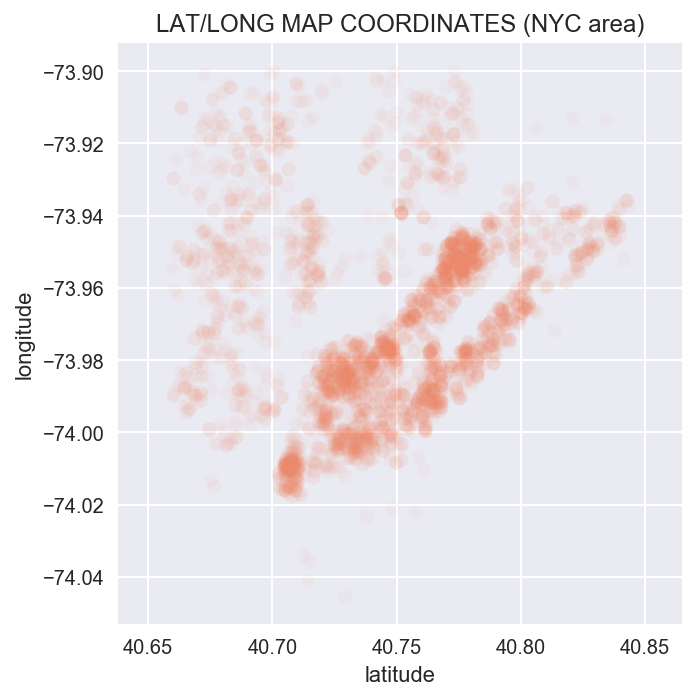

In [41]:
plot_coords(df.assign(clust=clust.labels_==-1), hue='clust', alpha=.05)
plot_coords(df_[clust.labels_==-1], alpha=.05)

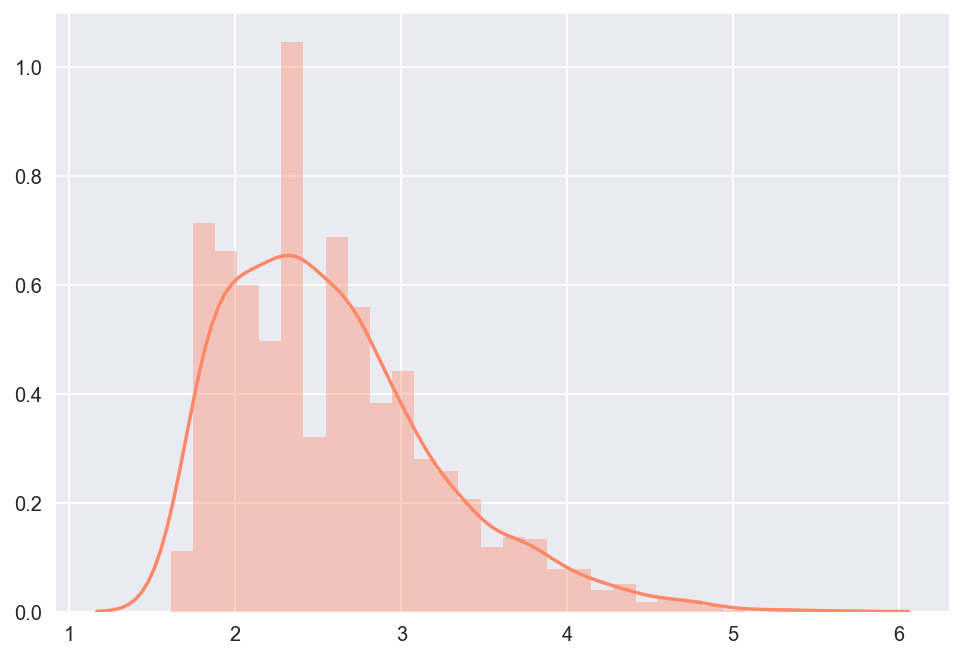

In [42]:
cnts = sorted(np.bincount(clust.labels_+1), reverse=True)[1:]
sns.distplot(np.log(cnts), )

In [43]:
sns.color_palette('Reds')

[(0.99506343713956169, 0.85965397923875431, 0.79866205305651672),
 (0.9882352941176471, 0.68667435601691651, 0.57788542868127646),
 (0.98658977316416763, 0.50672818146866594, 0.38123798539023457),
 (0.95700115340253744, 0.30871203383314111, 0.22191464821222606),
 (0.83704728950403684, 0.13394848135332565, 0.13079584775086506),
 (0.66634371395617076, 0.063391003460207609, 0.08641291810841982)]

In [44]:
sns.?*color*

SyntaxError: invalid syntax (<ipython-input-44-663136bb9473>, line 1)

In [ ]:
sns.?*color*

In [ ]:
sns.?*

In [ ]:
sns.?*color*

In [ ]:
df_ = df[df.latitude!=0]
df__ = df_[is_ou]

In [ ]:
plot_coords(data=df_)


In [ ]:
df

In [ ]:
type(next(buildings.get_group))

In [ ]:
 g= ((_, group) for _, group in buildings)

In [ ]:
next(g)[1]

In [ ]:
buildings = df.groupby('building_id')
is_consist = [True]*len(buildings)
for i, (_, group) in enumerate(buildings):

    if not (group[['latitude', 'longitude']].max() == group[['latitude', 'longitude']].min()).all():
        is_consistent[i] = False
        
df_ = df.assign(is_consistent=df.applymap)

In [ ]:
print('No. inconsistent building')

In [ ]:
df_ = df_apply

In [ ]:
from sklearn.cluster import DBSCAN, dbscan
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# scorer = make_scorer()


X = df_[['latitude', 'longitude']].iloc[:10000]
# db_clust = DBSCAN(n_jobs=-1)

In [ ]:
db_clust.

In [ ]:
params = dict(esp=np.arange(0.1, 0.5, 0.1), min_samples=np.arange(2, 10, 2))

gs_db = GridSearchCV(db_clust, param_grid=params)


gs_db.fit(X)

In [ ]:
db_clust.predict(X.iloc[:10])

In [ ]:
pd.Series(preds, name='preds')

In [ ]:
X.join(pd.Series(preds, name=name, index=X.index))
data=df.assign(preds=preds)

In [ ]:
pd.Series(clusterer.labels_).value_counts()



In [ ]:
clusterer.labels_.shape, df.shape

In [ ]:
import hdbscan
X = df_[['latitude', 'longitude']]
clust = hdbscan.HDBSCAN(min_cluster_size=15).fit(X)

In [ ]:
# clusterer.condensed_tree_.plot()


plot_coords(data=df.price,
            palette=sns.color_palette('Blues', n_colors=len(np.unique(clusterer.labels_))))
sns.palplot(sns.color_palette('Blues', n_colors=len(np.unique(clusterer.labels_))))

In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

In [ ]:
sns.distplot(np.log(df.price))

In [ ]:
pd.cut(X, bins=n_bins)

In [ ]:
n_bins = 100
X = np.log(df.price)
bins = sorted(np.unique(pd.cut(X, bins=n_bins)))
cats = dict(**{bin_:code for bin_, code in zip(bins, range(0, n_bins))})


In [ ]:
X.assign(X.price.replaprice_bins=cats)

In [ ]:
X.assign(price_bins=pd.cut(X, bins=10).replace(cats))

In [ ]:
plot_coords(data=pd.concat([pd.cut(df.price, bins=10).replace(cats).to_frame()), hue='price_bins',
            palette=sns.color_palette('Blues', n_colors=n_bins))

In [ ]:
df.price

In [ ]:
X = df_[['latitude', 'longitude', 'price']]

Best for KMeans: 13, 14 or 15 clusters (distortion=4.118, silhouette=0.492)

Best for AgglomerativeClustering: 15 (silhouette=0.479)

In [ ]:
MIN_CLUST = 10
MAX_CLUST = 50
SAMPLE_SIZE = .1  # for silhouette score
size = round(SAMPLE_SIZE*len(X))

distortions = []
scores = []
for n_clust in range(MIN_CLUST, MAX_CLUST+1):
    km = KMeans(n_clusters=n_clust)
    km.fit(X)
    
    preds = km.predict(X)
    
    samp_idx = np.random.choice(range(0, len(X)), size=size, replace=False)
    X_sample, preds_sample = X[samp_idx], preds[samp_idx]
    
    score = silhouette_score(X_sample, preds_sample) if n_clust > 1 else 1
    scores.append(score)
    
    distortions.append(km.inertia_)
#     print(km.inertia_, score)

In [ ]:
if False:
    MIN_CLUST = 10
    MAX_CLUST = 20
    SAMPLE_SIZE = .1  # for silhouette score
    size = round(SAMPLE_SIZE*len(X))

    scores = []
    for n_clust in range(MIN_CLUST, MAX_CLUST+1):
        km = AgglomerativeClustering(n_clusters=n_clust)



        samp_idx = np.random.choice(range(0, len(X)), size=size, replace=False)
        X_sample = X[samp_idx]

        preds = km.fit_predict(X_sample)
        score = silhouette_score(X_sample, preds) if n_clust > 1 else 1
        scores.append(score)

        print(score)
        
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(MIN_CLUST, MAX_CLUST+1), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')

plt.subplot(1, 2, 2)
plt.plot(range(MIN_CLUST, MAX_CLUST+1), scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

In [ ]:
if False:
    sns.lmplot(x='latitude', y='longitude', hue='preds', data=df.assign(preds=preds), fit_reg=False)

# Learning - Classification (vs ordinal regression)

__About the target variable__:
- From Kaggle: "The target variable, interest_level, is defined by the number of inquiries a listing has in the duration that the listing was live on the site."
- This means listings taken down quickly due to a quick close will be classified with the same interest level as one that takes longer to close and has the same number of inquiries.
- If we take a more holistic approach to interest level, another distortion could arise with listings that have lots of inquiries due to listings that are higher quality relative to the actual property.
- Ultimately, the distorting factor of duration is unknown because, assuming the listing were shown as they are now, the search ranking is determined not only by "freshness" but also by the quality of the posting and the property itself (possibly derived from interest level). 

__Dealing with class imbalance__:
- High: 0.078, medium: 0.228, low: 0.695
- https://stats.stackexchange.com/questions/122409/why-downsample

_Logistic Regression__
- Cost function favors majority class
- `Sklearn` implementation has `weight` parameter with `balanced` option.

__Dealing with outliers__:
- Examine with HDBSCAN
- Look at classes of outliers

__Logistic Regression__:
- http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
- `Liblinear` only compatible with `ovr`, use others for `multinomial`
- For build-in CV for regularization strength, use: [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV)

## Spot-check algorithms

Random guessing score:

In [261]:
df = read_rental_interest(TRAIN_FP)

In [270]:
y = LabelBinarizer().fit_transform(df.interest_level)
rnd_pred = y.copy()
random.shuffle(rnd_pred)
log_loss(y, rnd_pred)

15.953678608736908

In [277]:
avg_probs = (np.sum(y, axis=0)/len(y)).tolist()
baseline_pred = np.array(avg_probs*len(y)).reshape(-1, 3)
baseline_score = log_loss(y, baseline_pred)
baseline_score

0.78857691143225461

### Standardization and scaling

- For logistic regression and gradient boosting, putting variables on same scale improved speed of convergence

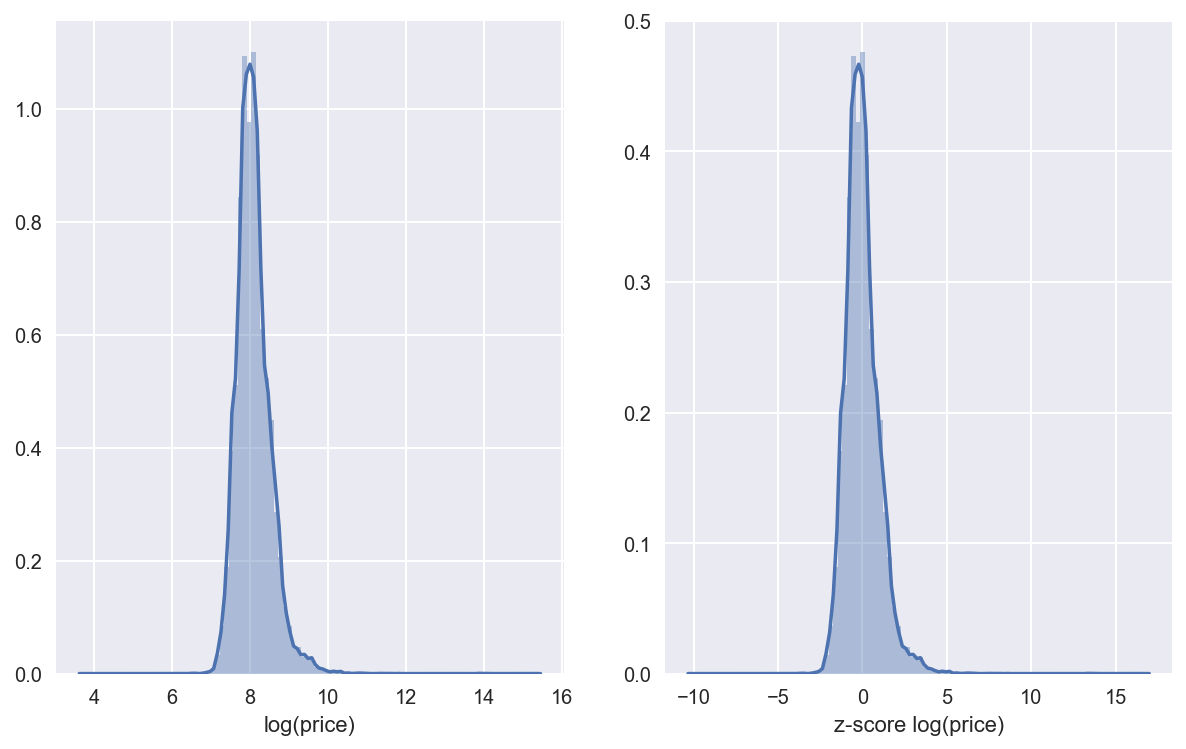

In [348]:
sns.set()

price_std = StandardScaler().fit_transform(
    np.log(df.price.astype(float).values.reshape(-1,1))
)
data = df.assign(price_std=price_std)

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(10, 6))
sns.distplot(
    np.log(data.price), ax=ax1, bins=100).set_xlabel('log(price)')

sns.distplot(
    data.price_std, ax=ax2, bins=100).set_xlabel('z-score log(price)')

### Spot-check

In [403]:
X = df.loc[:, ['bathrooms', 'bedrooms', 'price']]
y = LabelEncoder().fit_transform(df.interest_level)

In [405]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.5, random_state=SEED, stratify=y)

In [406]:
def best_grid_results(grid):
    results = []
    results.append('Best score: {:.5f}\n'.format(grid.best_score_))
    results.append('*** For parameters: ***')
    for param, val in grid.best_params_.items():
        results.append('{}: {}'.format(param, val))
    return '\n'.join(results)

##### Algorithm: `DecisionTreeClassifier`

In [407]:
from sklearn.tree import DecisionTreeClassifier

parameters = dict(
    criterion=['gini', 'entropy'],
    min_samples_split=range(2, 3000, 200),
)
clf = DecisionTreeClassifier(random_state=SEED)
grid = GridSearchCV(clf, parameters, n_jobs=-1, scoring=scoring)
grid.fit(X_train, y_train)

print(best_grid_results(grid))

Best score: -0.71658

*** For parameters: ***
criterion: entropy
min_samples_split: 1602


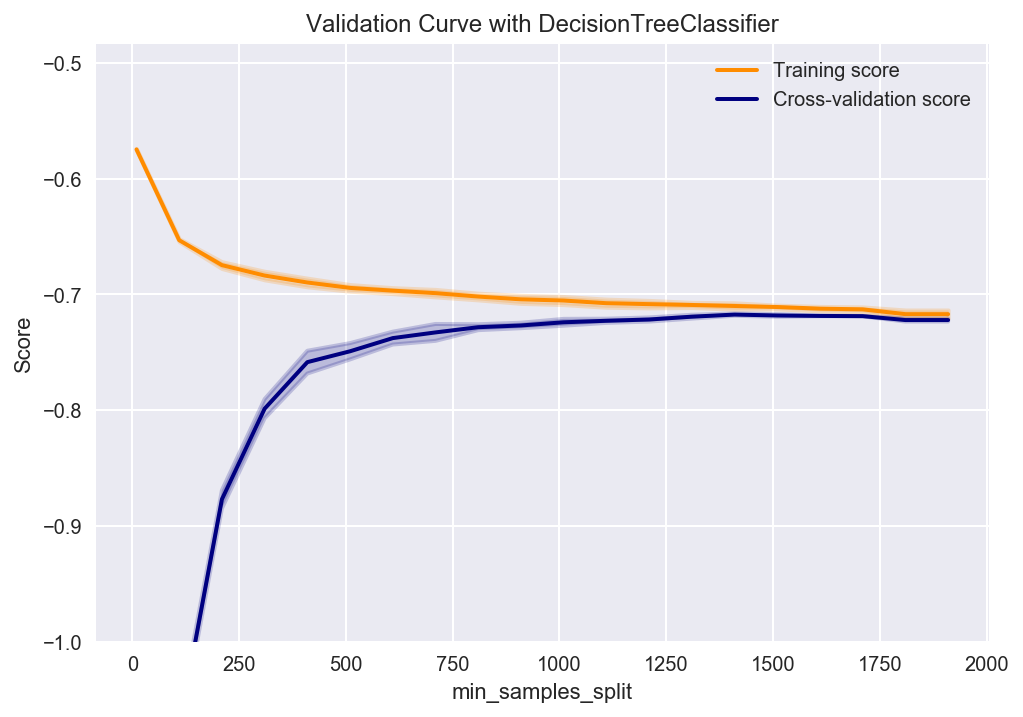

In [366]:
plot_validation_curve(grid, 'min_samples_split', range(10, 2000, 100),
                      scorer, ylim=(-1,))
plt.show()

In [411]:
y = LabelBinarizer().fit_transform(y)

In [412]:
y

array([[0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       ..., 
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]], dtype=int64)

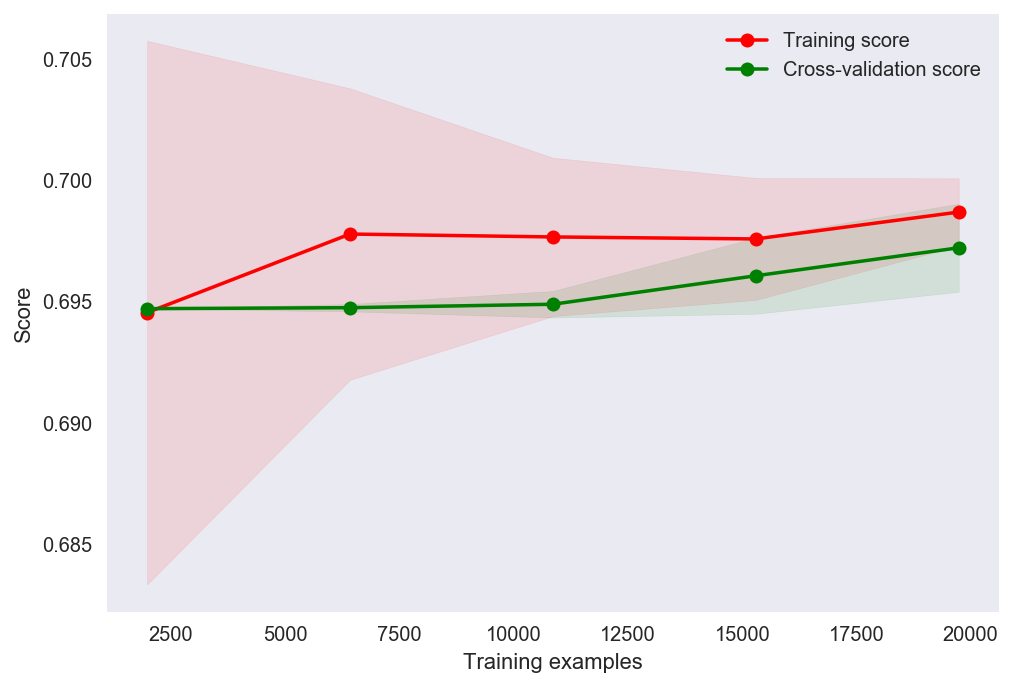

In [381]:
clf = deepcopy(grid.best_estimator_)
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=SEED)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    plot_learning_curve(clf, X_train, y_train, cv=cv,
                        n_jobs=-1)

- Both plots show over-fitting

##### Algorithm: `RandomForestClassifier`

In [398]:
from sklearn.ensemble import RandomForestClassifier
parameters = dict(
    criterion=['gini', 'entropy'],
    n_estimators=range(10, 600, 100),
    min_samples_split=range(100, 300, 20),
)

clf = RandomForestClassifier(random_state=SEED)
grid = GridSearchCV(clf, parameters, n_jobs=-1, scoring=scoring)
grid.fit(X_train, y_train)

print(best_grid_results(grid))

Best score: -0.70445

*** For parameters: ***
n_estimators: 510
criterion: gini
min_samples_split: 240


In [236]:
clf = RandomForestClassifier(n_estimators=50, min_samples_split=800)
clf.fit(X_train, y_train)

y_pred = clf.predict_proba(X_train)
print('Train score: {:>10.5f}'.format(log_loss(y_train, y_pred)))

y_pred = clf.predict_proba(X_test)
print('Test score : {:>10.5f}'.format(log_loss(y_test, y_pred)))

Train score:    0.69761
Test score :    0.70325


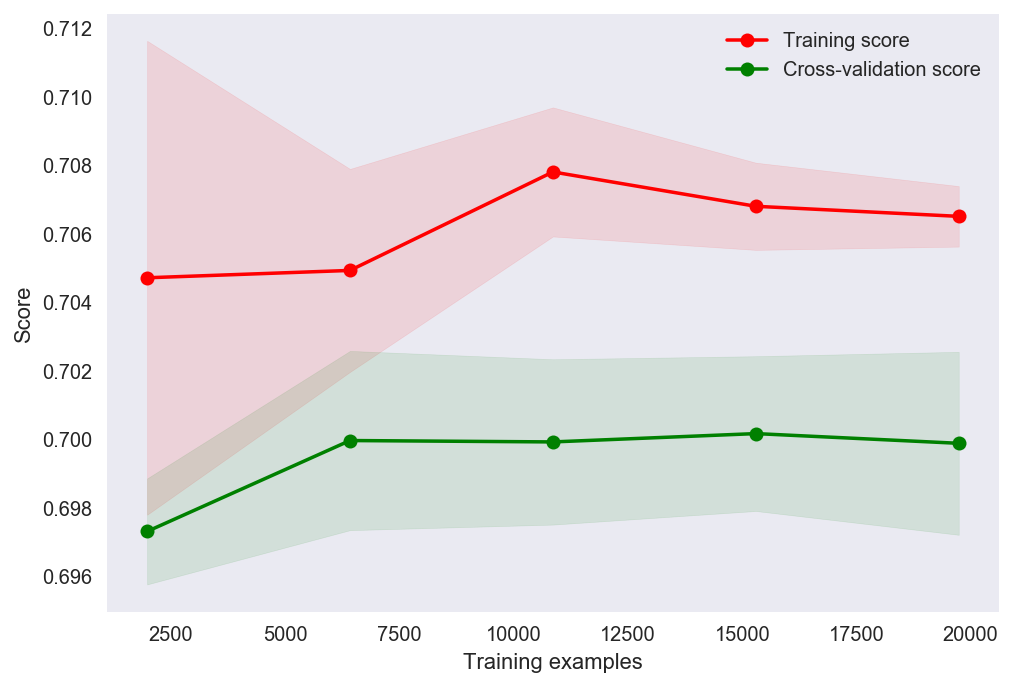

In [237]:
clf = deepcopy(rf_gs.best_estimator_)
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    plot_learning_curve(clf, X_train, y_train, cv=cv)

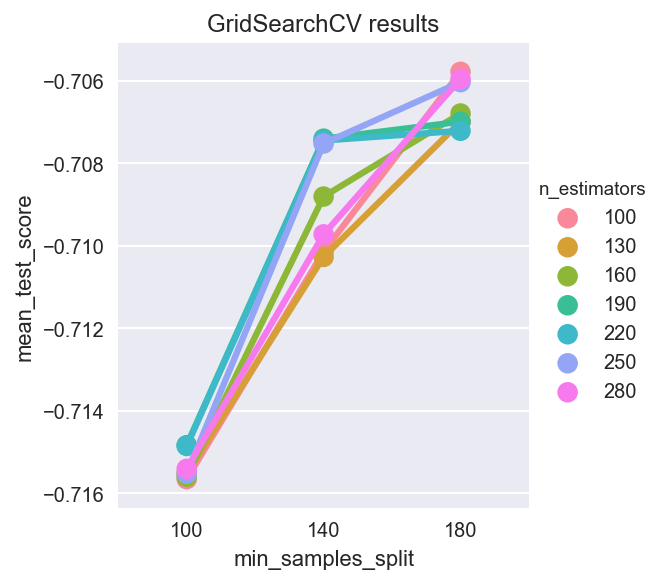

In [238]:
kinds = ['point', 'bar', 'count', 'box', 'violin', 'strip']
gx = GridSearchExplorer(rf_gs)
gx.plot(x='min_samples_split', hue='n_estimators', kind=kinds[0])

##### Algorithm: `GradientBoostingClassifier`

In [239]:
parameters = {
    'min_samples_split': range(2, 44, 4),
    'learning_rate': np.linspace(0.1, 0.4, 5)
#     'max_depth': range(3, 7, 1),
              }

clf = GradientBoostingClassifier(random_state=None)
grid = GridSearchCV(clf, parameters, n_jobs=-1, scoring=scoring)
grid.fit(X_train, y_train)

print(best_grid_results(grid))

Best score: 0.70221

*** Best parameters: ***
min_samples_split: 30
learning_rate: 0.175


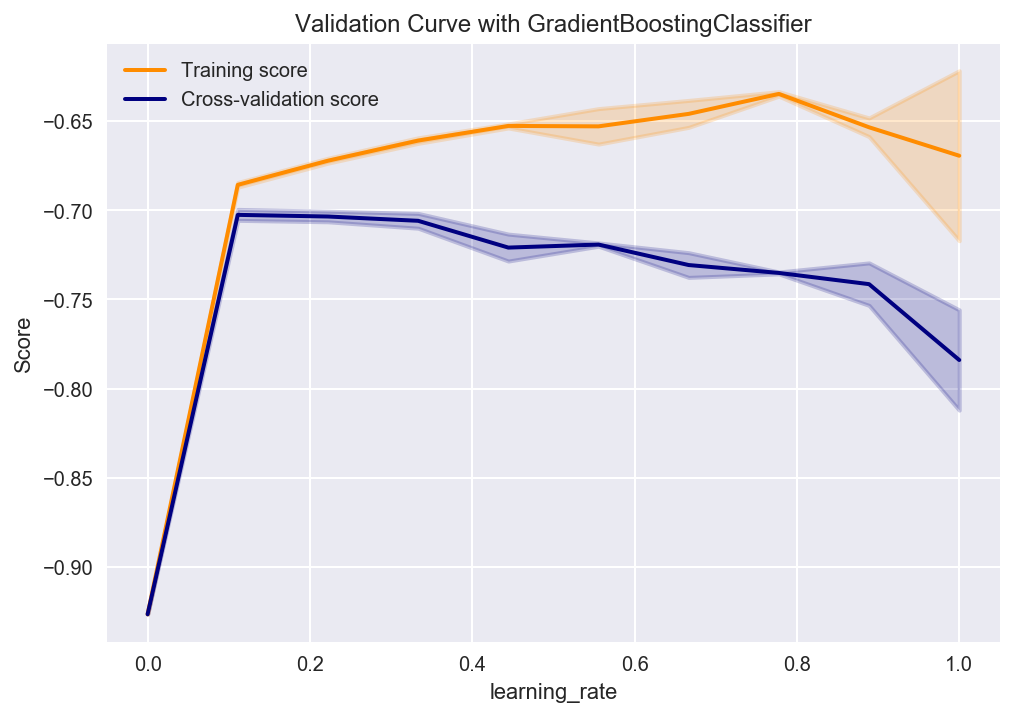

In [240]:
clf = GradientBoostingClassifier()

param_name = 'min_samples_split'
param_range = range(100, 1000, 50)

param_name = 'learning_rate'
param_range = np.linspace(1e-5, 1, 10)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    plot_validation_curve(clf, param_name, param_range, scorer=scoring)       


In [241]:
clf = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=26,
                                 random_state=None)
clf.fit(X_train, y_train)

y_pred = clf.predict_proba(X_train)
print('Train score: {:>10.5f}'.format(log_loss(y_train, y_pred)))

y_pred = clf.predict_proba(X_test)
print('Test score : {:>10.5f}'.format(log_loss(y_test, y_pred)))

Train score:    0.69157
Test score :    0.69962


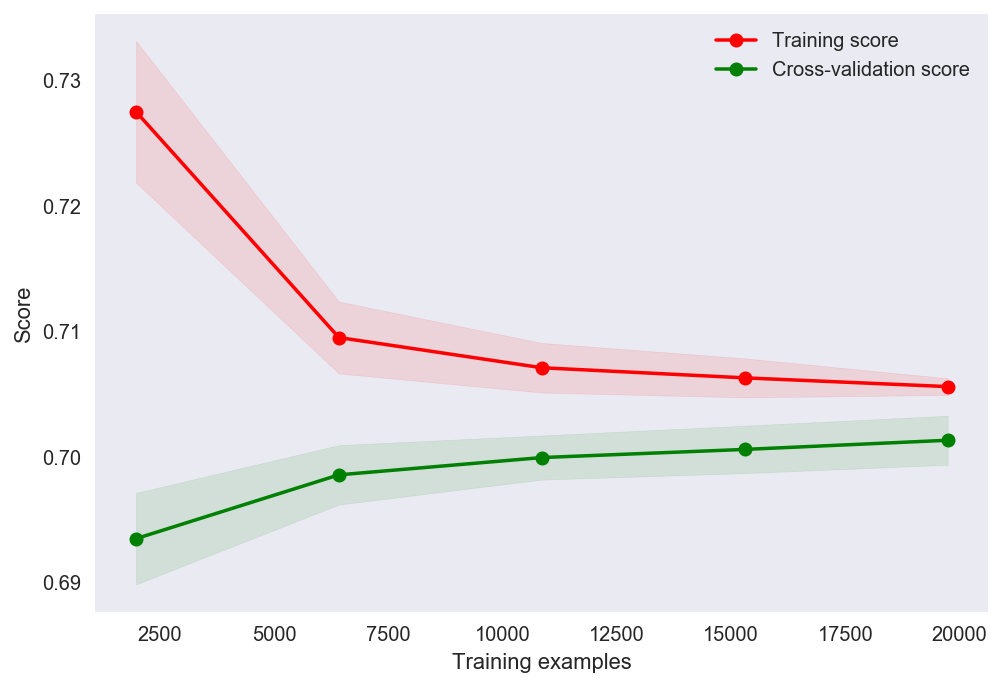

In [242]:
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    plot_learning_curve(clf, X_train, y_train, cv=cv)

##### Algorithm: Logistic Regression

In [243]:
parameters = {'penalty': ['l2'],
#               'C': np.logspace(-2.0, 10.0, 10),
#               'C': [1, 1.3, 1.6, 1.9, 2.2],
#                
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag'],
#               'solver': ['newton-cg', 'lbfgs', 'sag'],
#               'multi_class': ['ovr', 'multinomial'],
#               'fit_intercept': [True, False]
             }
clf = LogisticRegression(random_state=None)
grid = GridSearchCV(clf, parameters, n_jobs=-1, scoring=scoring,
                     error_score=np.nan)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    grid.fit(X_train, y_train)

print(best_grid_results(grid))

Best score: 0.73271

*** Best parameters: ***
penalty: l2
solver: newton-cg


In [ ]:
# not working???? freezes up, no processing happening

# from sklearn.model_selection import validation_curve


# clf = LogisticRegression(n_jobs=-1)
# param_name = 'C'
# param_range = np.logspace(-2.0, 10.0, 10)

# with warnings.catch_warnings():
#     warnings.simplefilter('ignore')
#     plot_validation_curve(clf, param_name, param_range,
#                           scorer=scoring, xscale='log')

In [ ]:
# not working???? freezes up, no processing happening

# clf = LogisticRegression()
# cv = StratifiedShuffleSplit(n_splits=100, test_size=0.2)

# with warnings.catch_warnings():
#     warnings.simplefilter('ignore')
#     plot_learning_curve(clf, X_train, y_train, cv=cv)

### Spot-check submissions

In [ ]:
X_sub = (pd.read_json(TEST_FP)
         .set_index('listing_id')
        .loc[:, BASIC_FEATURES])

sample_sub = (pd.read_csv(SAMPLE_FP)
              .set_index('listing_id'))

#### 0) `GradientBoostingClassifier`

- Best score from GridSearch: 0.675
- Leaderboard score: 0.70353

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(
    learning_rate=0.01, n_estimators=1190)
gb_clf = gb_clf.fit(X, y)
preds = gb_clf.predict_proba(X_sub)

In [ ]:
if False:  # to preserve original submission file
    submit_0 = save_submission(preds, ''.join([SUBM_DIR, 'submit_0.csv']))

#### 1) `RandomForestClassifier`

- Best score from GridSearch: 0.674
- Leaderboard score: 1.43743

In [ ]:
from sklearn.ensemble import RandomForestClassifier
parameters = {'criterion': 'gini', 'min_samples_split': 300}
rf_clf = RandomForestClassifier(random_state=None,
                                min_samples_split=300,
                                n_estimators=1400)
rf_clf.fit(X, y)
preds = rf_clf.predict_proba(X_sub)

In [ ]:
if False:  # to preserve original submission file
    submit_1 = save_submission(preds, ''.join([SUBM_DIR, 'submit_1.csv']))

## Feature Engineering

In [ ]:
BASIC_FEATURES = ['bathrooms', 'bedrooms', 'price']
TARGET =  ['interest_level']


df = read_rental_interest_json(TRAIN_FP)
df_ = df[BASIC_FEATURES+TARGET]

y = LabelEncoder().fit_transform(df.interest_level)
X = df.drop('interest_level', axis=1)

X_train, X_test, y_train, y_test = (
    train_test_split(
        X, y, test_size=.2, stratify=y)
    )

X_train.shape

In [ ]:
np.bincount(y)

### Feature lists

#### Explore

In [ ]:
n_feats = df.features.map(lambda x: len(x))
plt.hist(n_feats, cumulative=True, normed=True, bins=300, align='left')
plt.title('CDF of number of features for each listing.')
print('min: {} (n={})\nmed: {}\nmax: {}'.format(
    n_feats.min(), (n_feats==0).sum(),
    n_feats.median(), n_feats.max()))
# n_feats.value_counts(normalize=True).sort_index()

In [ ]:
def contains_punc(criteria, feats_list, regex=False):
    """Checks for punctuation in feature list.
    
    Can be used to determine the nature of difference
    puncuations.
    
    Parameters
    ----------
    criteria : list of str or raw/str
        list of punctuation marks, or regex to match punctuation
    feats_list : list
    
    Returns
    -------
    has_punc : bool
    """
    
    if regex:
        reg = re.compile(criteria)
    
    # return True 
    for feat in feats_list:
        if regex:
            if reg.match(feat):
                return True
        else:
            for s in criteria:
                if s in feat:
                    return True
    
    # if no punctuation found in list of features
    return False

In [ ]:
from collections import Counter
import re

def extract_clean_feats(feats):
    """Extract and normalize each feature in list."""
    
#     cleaner = lambda x: re.sub(r'[ ]*[^\w ][ ]*', ' ', x)
    cleaner = lambda x: x.upper().strip().replace('-', '')
#     cleaner = lambda x: x
    cleaned = (cleaner(feat) for feat in feats)
    
    return cleaned


def count_feats(feat_col):
    """Extracts features from list and returns counter."""
    
    cnt = Counter()
    for _, feats in feat_col.iteritems():
        feats = set(extract_clean_feats(feats))  # remove dupes too
        cnt.update(feats)
        
    return cnt

feat_cnts = count_feats(df.features)
feat_cnts.most_common(5)

In [ ]:
df[df.features.map(lambda x: contains_punc(['*'], x))].head(2)

#### Include feature lists in model

In [ ]:
def binarize_from_list_vals(col):
    """Transforms Series of lists to dummy variables."""
    
    SEP = '~~//'  # any value that won't be in strings in list

    cleaned = col.apply(lambda x: extract_clean_feats(x))
    dummies = cleaned.str.join(sep=SEP).str.get_dummies(sep=SEP)

    return dummies


In [ ]:
# Testing against feature counter
# Discrepency caused by duplicate feats within a list
# Fix this with set() call in count_feats

if 1==0:
    feats_df = binarize_from_list_vals(df.features)

    results = []

    for i, (feat, cnt) in enumerate(feat_cnts.items()):
        try:
            cnt_dumm = feats_df[feat].sum()
            if cnt != cnt_dumm:
    #             print("Mismatch...\ndummies: {}\ncounter: {}\n'{}'\n"
    #                   .format(cnt_dumm, cnt, feat))
                results.append(dict(feat=feat, cnt_dumm=cnt_dumm, cnt=cnt))   
        except KeyError:
            results.append("Missing from dummies:\n'{}'\n".format(feat))
    #         break  # since it is not included in results list of dicts

    assert not results  # no discrepencies!

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()

feats_train = feats_df.loc[X_train.index]
feats_test = feats_df.loc[X_test.index]

pca.fit(feats_train)

In [ ]:
list(pca.explained_variance_ratio_[:4])

In [ ]:
plt.title('Cumulative Explained Variance for PCA')

plt.plot(np.cumsum(pca.explained_variance_ratio_))

plt.xlim(0, 150)
plt.xlabel('components')
plt.ylabel('cumulative explained variance');

In [ ]:
N_COMPONENTS = 1000
# N_COMPONENTS = len(pca.components_)

cols = ['FeatComp{}'.format(i+1) for i in range(0, N_COMPONENTS)]

reduced_train = pd.DataFrame(
    pca.transform(feats_train)[:, :N_COMPONENTS], 
    columns=cols, index=feats_train.index
)
reduced_test  = pd.DataFrame(
    pca.transform(feats_test)[:, :N_COMPONENTS], 
    columns=cols, index=feats_test.index
)

# allows rejoining reduced data after reprocessing
X_train = X_train.loc[:, ~X_train.columns.isin(cols)]
X_test  = X_test.loc[:, ~X_test.columns.isin(cols)]

X_train = X_train.join(reduced_train)
X_test  = X_test.join(reduced_test)

In [ ]:
N = len(feats_train)

In [ ]:
steps = [('reducer', PCA()),
         ('clf', GradientBoostingClassifier(min_samples_split=50))]
pipe = Pipeline(steps=steps)

params = {
    'reducer': [PCA(), TruncatedSVD()],
    'reducer__n_components': [200, 300, 400],
#     'clf__min_samples_split': [120],
#     'clf__learning_rate': np.linspace(0.1, 0.4, 5),
#     'clf__learning_rate': [0.05, 0.1, 0.15],
#     'clf_max_depth': range(3, 7, 1),
#     'pca__n_components': [10, 20, 25],
#     'pca__n_components': [10, 40],
#     'clf__min_samples_split': [120, 180],
              }

grid = GridSearchCV(pipe, params, scoring=scoring, n_jobs=-1)
grid.fit(feats_train.iloc[:N], y_train[:N])
grid.best_score_

In [ ]:
gx = GridSearchExplorer(grid)
gx.plot(x='reducer__n_components', hue='reducer')

#### Combine with BASIC

In [244]:
from sklearn.base import TransformerMixin

class DateEncoder(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        dt = X.dt
        return pd.concat([dt.year, dt.month, dt.day], axis=1)
dates_df = pd.DataFrame(
    {'dates': pd.date_range('2015-10-30', '2015-11-02')})
mapper_dates = DataFrameMapper([
    ('dates', DateEncoder())
], input_df=True)
mapper_dates.fit_transform(dates_df)


NameError: name 'DataFrameMapper' is not defined

In [ ]:
from sklearn_pandas import DataFrameMapper

class LogTransformer(TransformerMixin):
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        return np.log(X)
    
dm = DataFrameMapper([
    (['bedrooms', 'bathrooms'], MinMaxScaler()),
    (['price'], [LogTransformer(), MinMaxScaler()])
])

dm.fit_transform(df)

In [ ]:
FEATURES = ['bathrooms', 'bedrooms', 'price', 'features']
TARGET =  ['interest_level']


df = read_rental_interest_json(TRAIN_FP, frac=.)
df_ = df[FEATURES+TARGET]


y = LabelEncoder().fit_transform(df.interest_level)
feats_bow = binarize_from_list_vals(df.features)

In [ ]:
X = df.drop(['interest_level', 'features'], axis=1).values
X = np.hstack((X, feats_bow))

X_train, X_test, y_train, y_test = (
    train_test_split(
        X, y, test_size=.2, stratify=y)
    )


X_train.shape

In [ ]:
from sklearn.svm import SVC


class FeatureSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, slice_):
        self.slice_ = slice_

    def fit(self, x, y=None):
        return self

    def transform(self, x, y=None):
        return x[:, self.slice_]


pipe = Pipeline([
    ('union', FeatureUnion([
        ('feature_list', Pipeline([
            ('selector', FeatureSelector(slice(3, None))),
            ('reducer', TruncatedSVD(n_components=100))
        ])),
        ('selector', FeatureSelector(slice(None, 3)))
    ])
    ),
    ('clf', GradientBoostingClassifier())
])

pipe.fit(X_train, y_train)

param_grid = {
#     'union__feature_list__reducer': [TruncatedSVD(), PCA()],
#     'union__feature_list__reducer__n_components': [100, 200],
    'clf__n_estimators': [100, 200, 500],
    'clf__min_samples_split': [2, 10, 50],
    'clf__learning_rate':[0.05, 0.1, .15]
#       'clf': [GradientBoostingClassifier(), SVC(probability=True),
#               RandomForestClassifier()]
}

grid = GridSearchCV(pipe, param_grid, scoring=scoring, n_jobs=-1)
grid.fit(X_train, y_train)
grid.best_score_

In [ ]:
grid.best_params_

In [ ]:
GridSearchExplorer(grid).plot(x='clf__n_estimators',
                              hue='clf__min_samples_split')

In [ ]:
from sklearn.svm import SVC


class FeatureSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, slice_):
        self.slice_ = slice_

    def fit(self, x, y=None):
        return self

    def transform(self, x, y=None):
        return x[:, self.slice_]


pipe = Pipeline([
    ('union', FeatureUnion([
        ('feature_list', Pipeline([
            ('selector', FeatureSelector(slice(3, None))),
            ('reducer', TruncatedSVD(n_components=100))
        ])),
        ('selector', FeatureSelector(slice(None, 3)))
    ])
    ),
    ('clf', GradientBoostingClassifier())
])

pipe.fit(X_train, y_train)

param_grid = {
#     'union__feature_list__reducer': [TruncatedSVD(), PCA()],
#     'union__feature_list__reducer__n_components': [100, 200],
    'clf__n_estimators': [100, 200, 500],
    'clf__min_samples_split': [2, 10, 50],
    'clf__learning_rate':[0.05, 0.1, .15]
#       'clf': [GradientBoostingClassifier(), SVC(probability=True),
#               RandomForestClassifier()]
}

grid = GridSearchCV(pipe, param_grid, scoring=scoring, n_jobs=-1)
grid.fit(X_train, y_train)
grid.best_score_

In [ ]:
gx = GridSearchExplorer(grid)
gx.plot(x='clf__learning_rate', hue='clf__n_estimators')

In [ ]:
# confusion matrix

### NLP with description feature:

In [ ]:
words = Counter()

def extract_words(feats):
    feats = [re.sub(r'[ ]*[^\w ][ ]*', ' ', s.upper())
             for s in feats]
    words = [word for s in feats for word in s.split()]
    
    return words

In [ ]:
for idx, feats in df.features.iteritems():
    words.update(extract_words(feats))

In [ ]:
words.most_common()

In [ ]:
df = read_rental_interest_json(TRAIN_FP)

In [ ]:
with open(TRAIN_FP) as f:
    x = f.read()
a = 10011000
x[a:a+540]

In [ ]:
s = 'itness gym, laundry facility & pet-friendly'

df[df.description.str.contains(s)].iat[0, 4]

- Strip:
    - leading spaces
    - html tags: `<br /><br />`
    - html entities?
    - returns: `\r`
    - weird separators
- Replace:
    - `w/ ` to `with`
    - `washer /dryer` and other unspaced slashes
    - `&` to `and`
- Separate words joined between sentences
    - e.g. `FloorsLimed Brick WallsPrivate BalconiesIntricate`
    - very important, lots of instances, spearate by caps
    - not possible when all caps
- Separate joined word without caps:
    - `Long Island Railroad isabout a 10 `

- New features:
    - Length of description
    - Has website (`website_redacted` or html tag)
    - Has email
    - Has phone number


In [ ]:
df.description.values[]
raise

In [ ]:
nlp = spacy.load('en')

### Other features

## Duplicates

In [ ]:
def are_duplicated(df, normed=True):
    dupe_ns = []
    dupes = {}
    for name, ser in df.iteritems():
        print(name)
        print(type(ser))
        n = ser[ser.duplicated(keep=False)].sum()
        if type(n) is not int:
            %debug
        if normed:
            if type(n) is not int:
                print(n)
            n /= len(df)
        dupe_ns.append(n)
        dupes[name] = n
    
    return pd.DataFrame(dupes).T

are_duplicated(df)